# Análisis Predictivo de Series Temporales



## Redes Neuronales aplicadas a Series Temporales


## Objetivo

El objetivo de este cuaderno es introducir algunos ejemplos de ajuste de redes neuronales en el contexto de análsiis de series temporales. En particular:

 * Discutir cómo convertir el problema de ajuste de modelos a un problema de aprendizaje supervisado.
 
 * Analizar la relación entre RNN clásicas y los modelos lineales ya vistos.
 
 * Discutir algunos ejemplos más complejos de redes (CNN, RNN, LSTM).
 
 * Observar cómo se puede realizar la predicción.
 
 
Nos basaremos en algunas bibliotecas de `R` que interactúan con `tensorflow`, por lo que es necesario una instalación de Python con tensorflow para que funcione. En particular usaremos la biblioteca `keras`.

In [5]:
# read in the packages we'll use
library(keras) # for deep learning
library(astsa)
options(repr.plot.width=8, repr.plot.height=4.5, repr.plot.res=300) #ajusta tamaño de graficas

### Ejemplo

Trabajaremos en un principio con la serie de mortalidad que ya vimos:

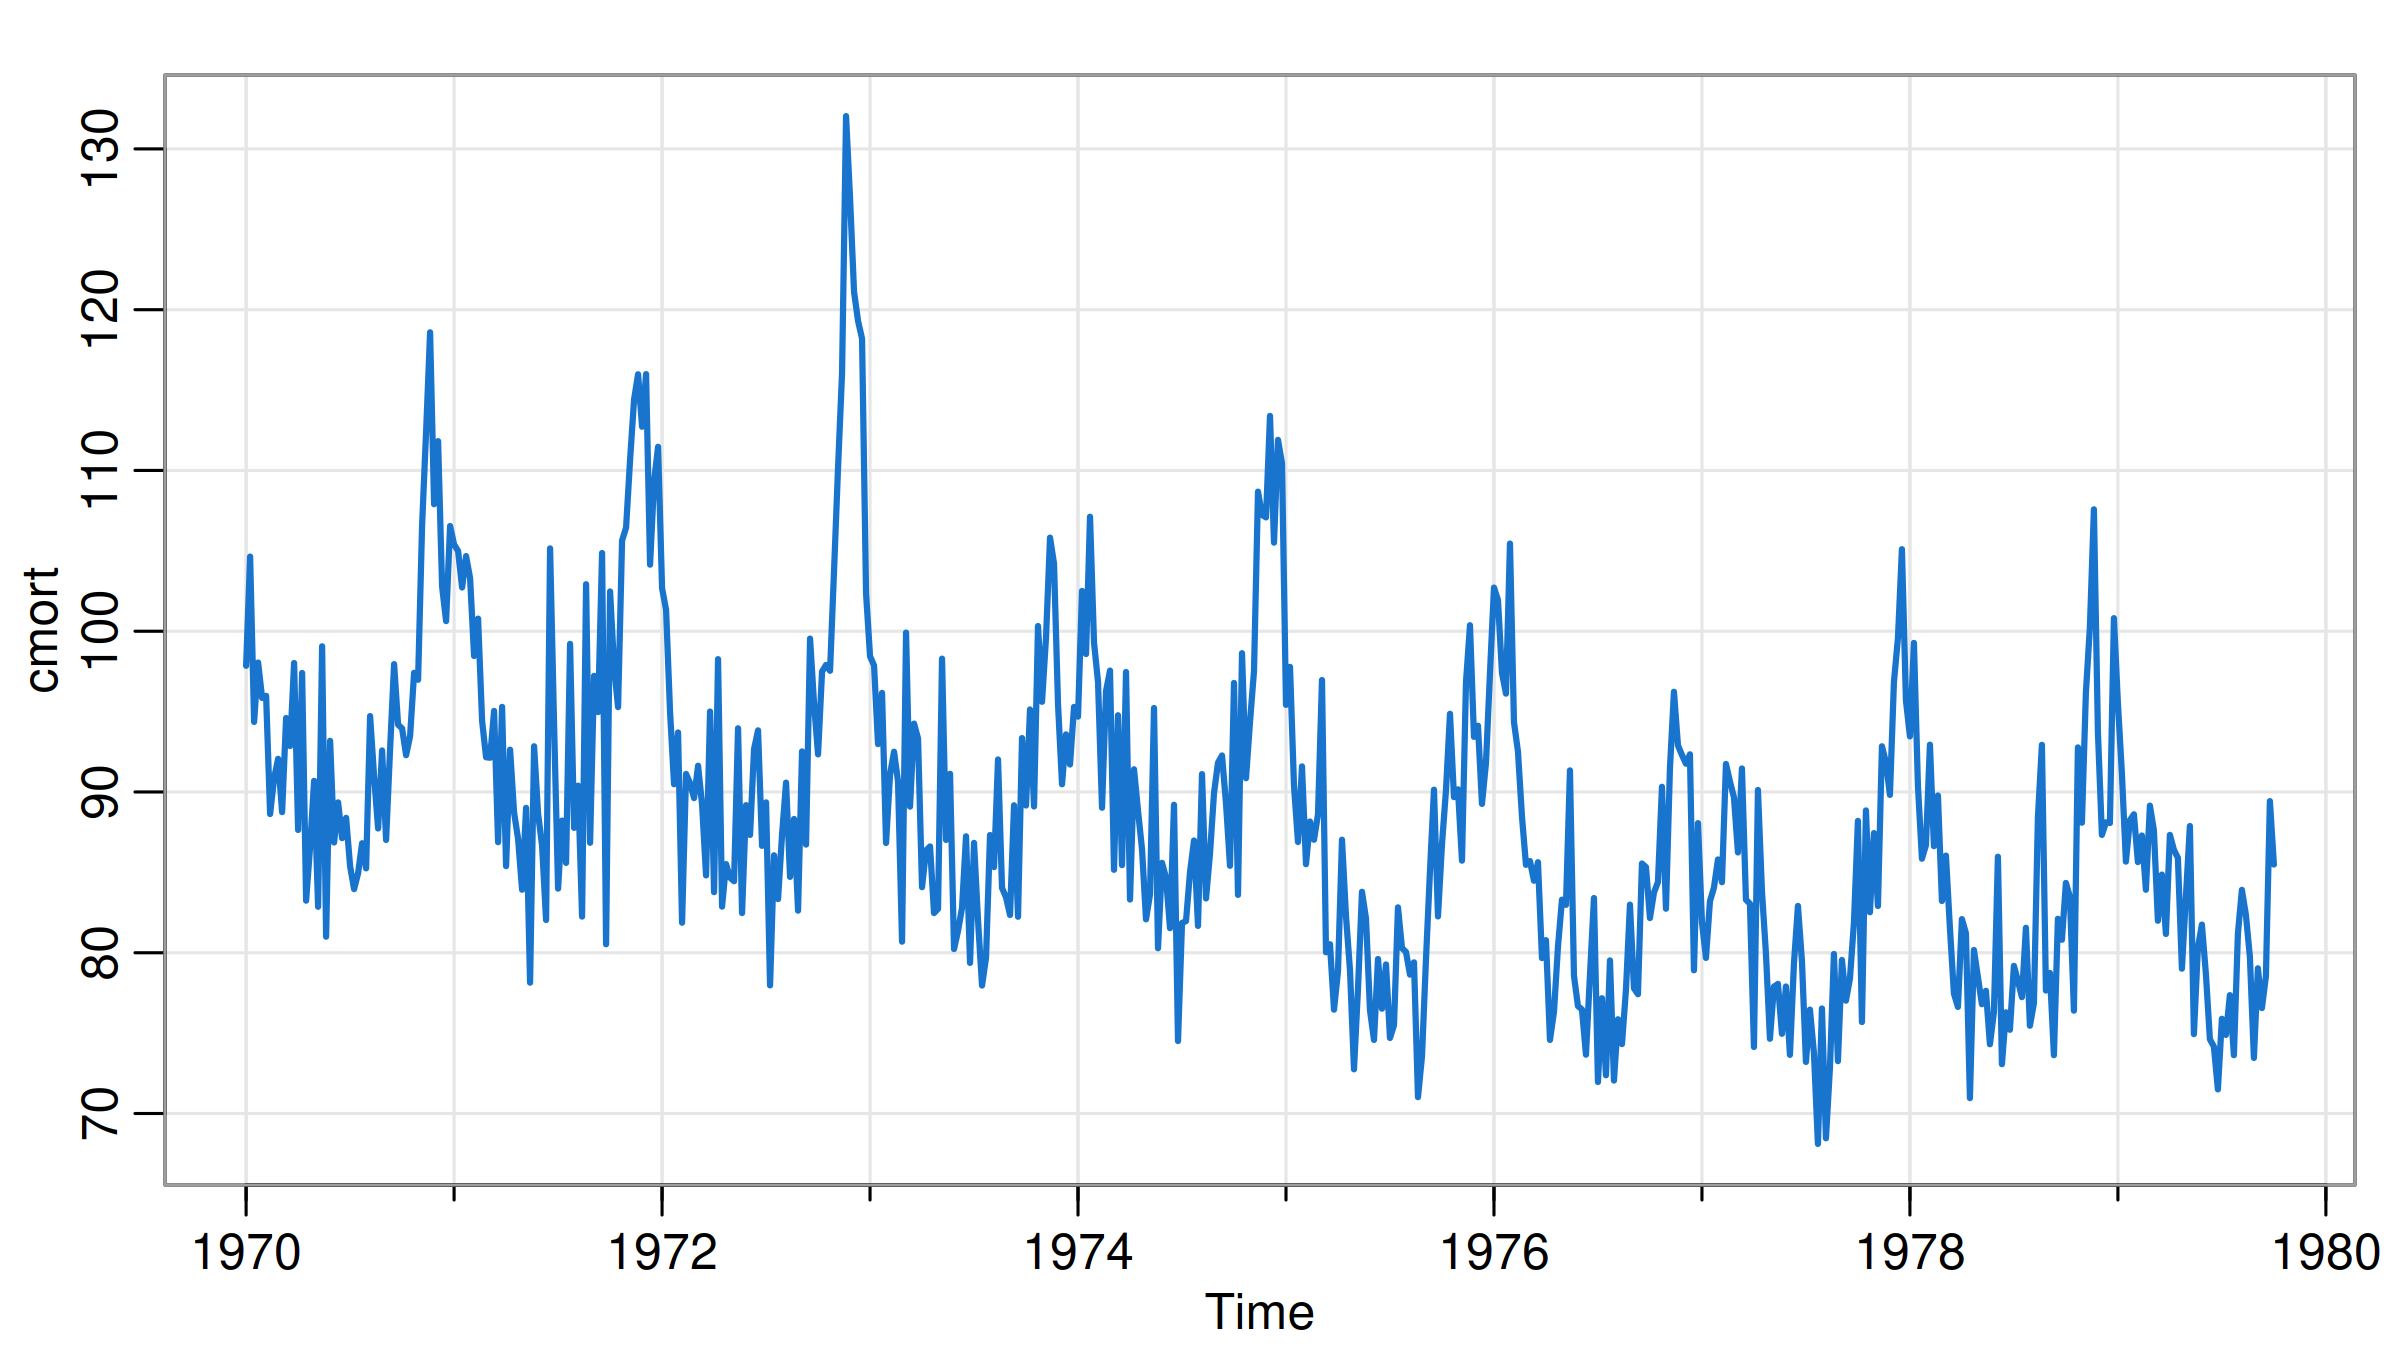

In [6]:
tsplot(cmort, lwd=2, col=4)

### Estacionarización

Como vimos antes, resulta útil llevar primero la serie a algo estacionario. En este caso, le quitamos la tendencia.

In [7]:
fit = lm(cmort~time(cmort))
summary(fit)


Call:
lm(formula = cmort ~ time(cmort))

Residuals:
    Min      1Q  Median      3Q     Max 
-16.445  -6.670  -1.366   5.505  40.107 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3297.6062   276.3132   11.93   <2e-16 ***
time(cmort)   -1.6249     0.1399  -11.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.893 on 506 degrees of freedom
Multiple R-squared:  0.2104,	Adjusted R-squared:  0.2089 
F-statistic: 134.9 on 1 and 506 DF,  p-value: < 2.2e-16


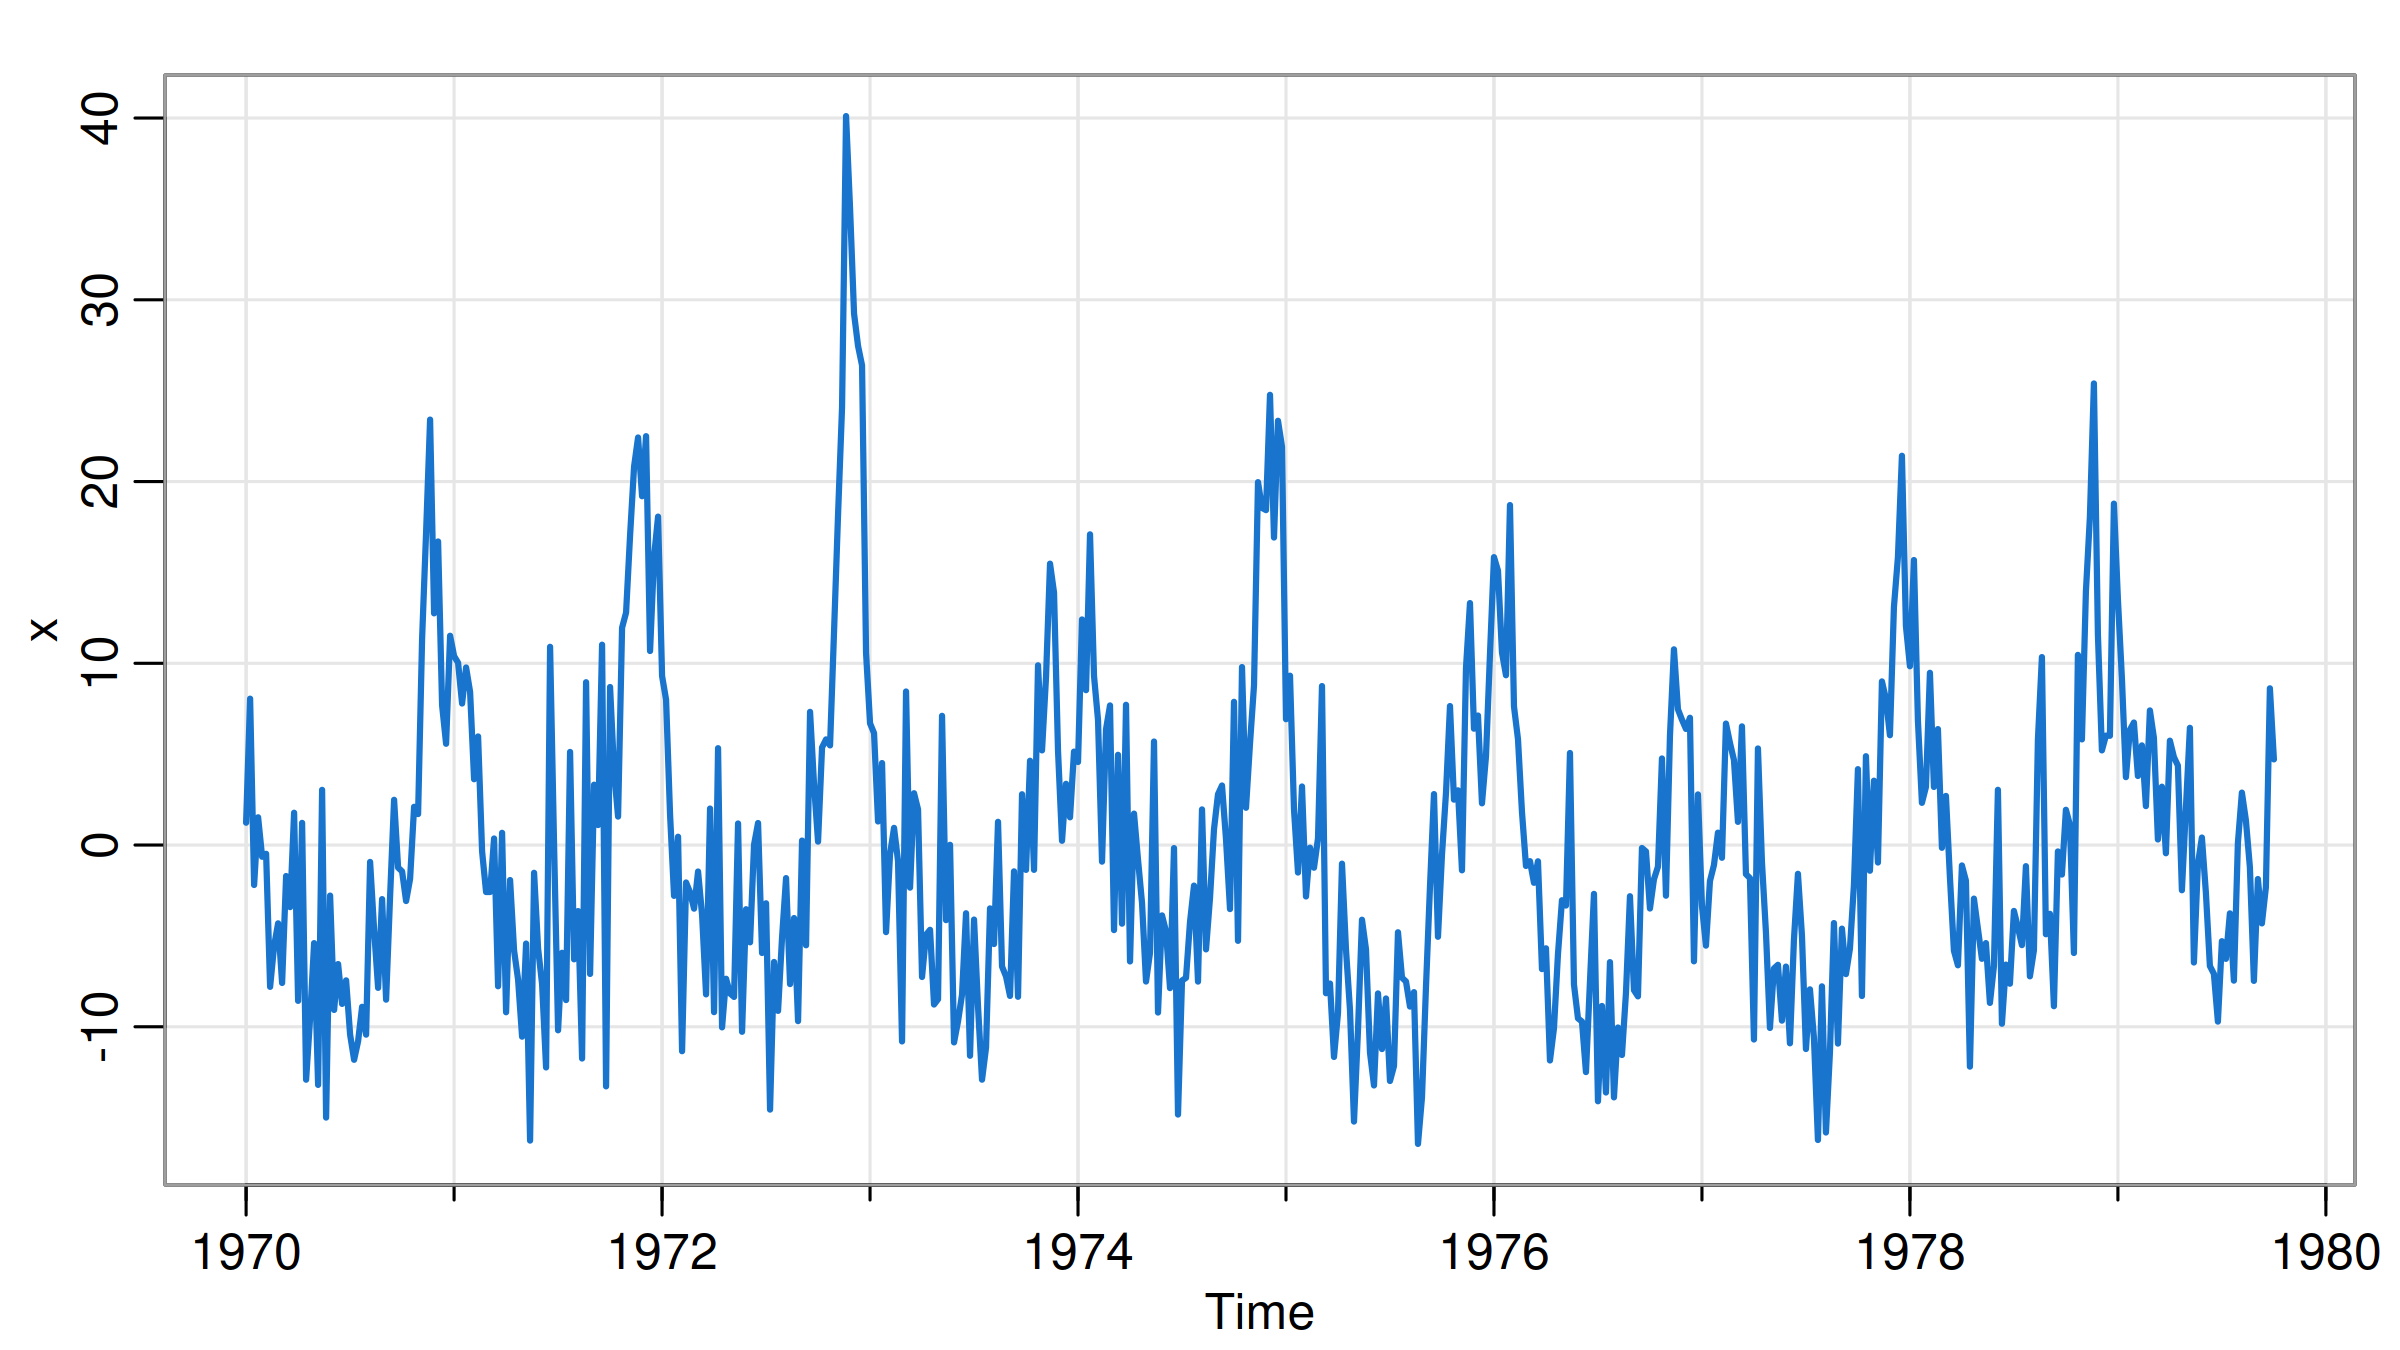

In [8]:
x=residuals(fit)
x=ts(x, start=1970, freq=52)
tsplot(x, lwd=2, col=4)

## Aprendizaje en series temporales

Las redes neuronales sirven para realizar aprendizaje *supervisado*, esto es, a partir de ejemplos, encontrar los coeficientes de la red que minimizan una función de *loss* o pérdida. En este caso:

* Los ejemplos son "ventanas" de valores en el tiempo de la serie, y uno o más features que nos interese incorporar:

     * Por ejemplo, el valor de la semana del año en este caso importa debido a la variación anual.
     * Pueden ser también diferentes "features" como la temperatura y partículas que ya vimos.
     
* El valor a predecir es por ejemplo, el siguiente valor de la serie, o una ventana hacia adelante.

* En base a esto, se arma una arquitectura de red y se entrena usando backpropagation.

### Diagrama

Para el caso por ejemplo de tomar 6 lags:

![split window](../images/split_window.png)

### Preprocesamiento

En este caso, haremos varios modelos. El primero simplemente usa como feature la propia serie, usando una cantidad `window` de lags. Separamos ademas una parte para testear predicciones.

In [9]:
window=3
pred = 1
x_train = x[time(x)<1978]

n=length(x_train)
print(n)

X_train = matrix(,n-window-pred+1,window)
y_train = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_train[i,] = x_train[i:(i+window-1)]
    y_train[i,] = x_train[(i+window):(i+window+pred-1)]
}
dim(X_train)
dim(y_train)

head(X_train)
head(y_train)
head(x_train)

[1] 416


[1] 413   3

[1] 413   1

[,1]       [,2]       [,3]      
[1,]  1.2299000  8.0511474 -2.1976052
[2,]  8.0511474 -2.1976052  1.5236423
[3,] -2.1976052  1.5236423 -0.6451103
[4,]  1.5236423 -0.6451103 -0.4838629
[5,] -0.6451103 -0.4838629 -7.8026155
[6,] -0.4838629 -7.8026155 -5.5513680

[,1]      
[1,]  1.5236423
[2,] -0.6451103
[3,] -0.4838629
[4,] -7.8026155
[5,] -5.5513680
[6,] -4.3101206

1          2          3          4          5          6 
 1.2299000  8.0511474 -2.1976052  1.5236423 -0.6451103 -0.4838629

In [10]:
# Armo el "tensor" de entrenamiento
X_train = array(X_train, dim = c(n-window-pred+1, window, 1))

#dimensiones: no. muestras, tiempos involucrados, no. features
dim(X_train)

[1] 413   3   1

## Modelo 1: una única capa densa.

Esto coincide con el modelo lineal del autorregresivo que ya vimos.

In [11]:
# initialize our model
model1 <- keras_model_sequential()

model1 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 1)

Loaded Tensorflow version 2.10.0



In [12]:
summary(model1)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 flatten (Flatten)                  (None, 3)                       0           
 dense (Dense)                      (None, 1)                       4           
Total params: 4
Trainable params: 4
Non-trainable params: 0
________________________________________________________________________________


In [13]:
model1 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [14]:
trained_model <- model1 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 300, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


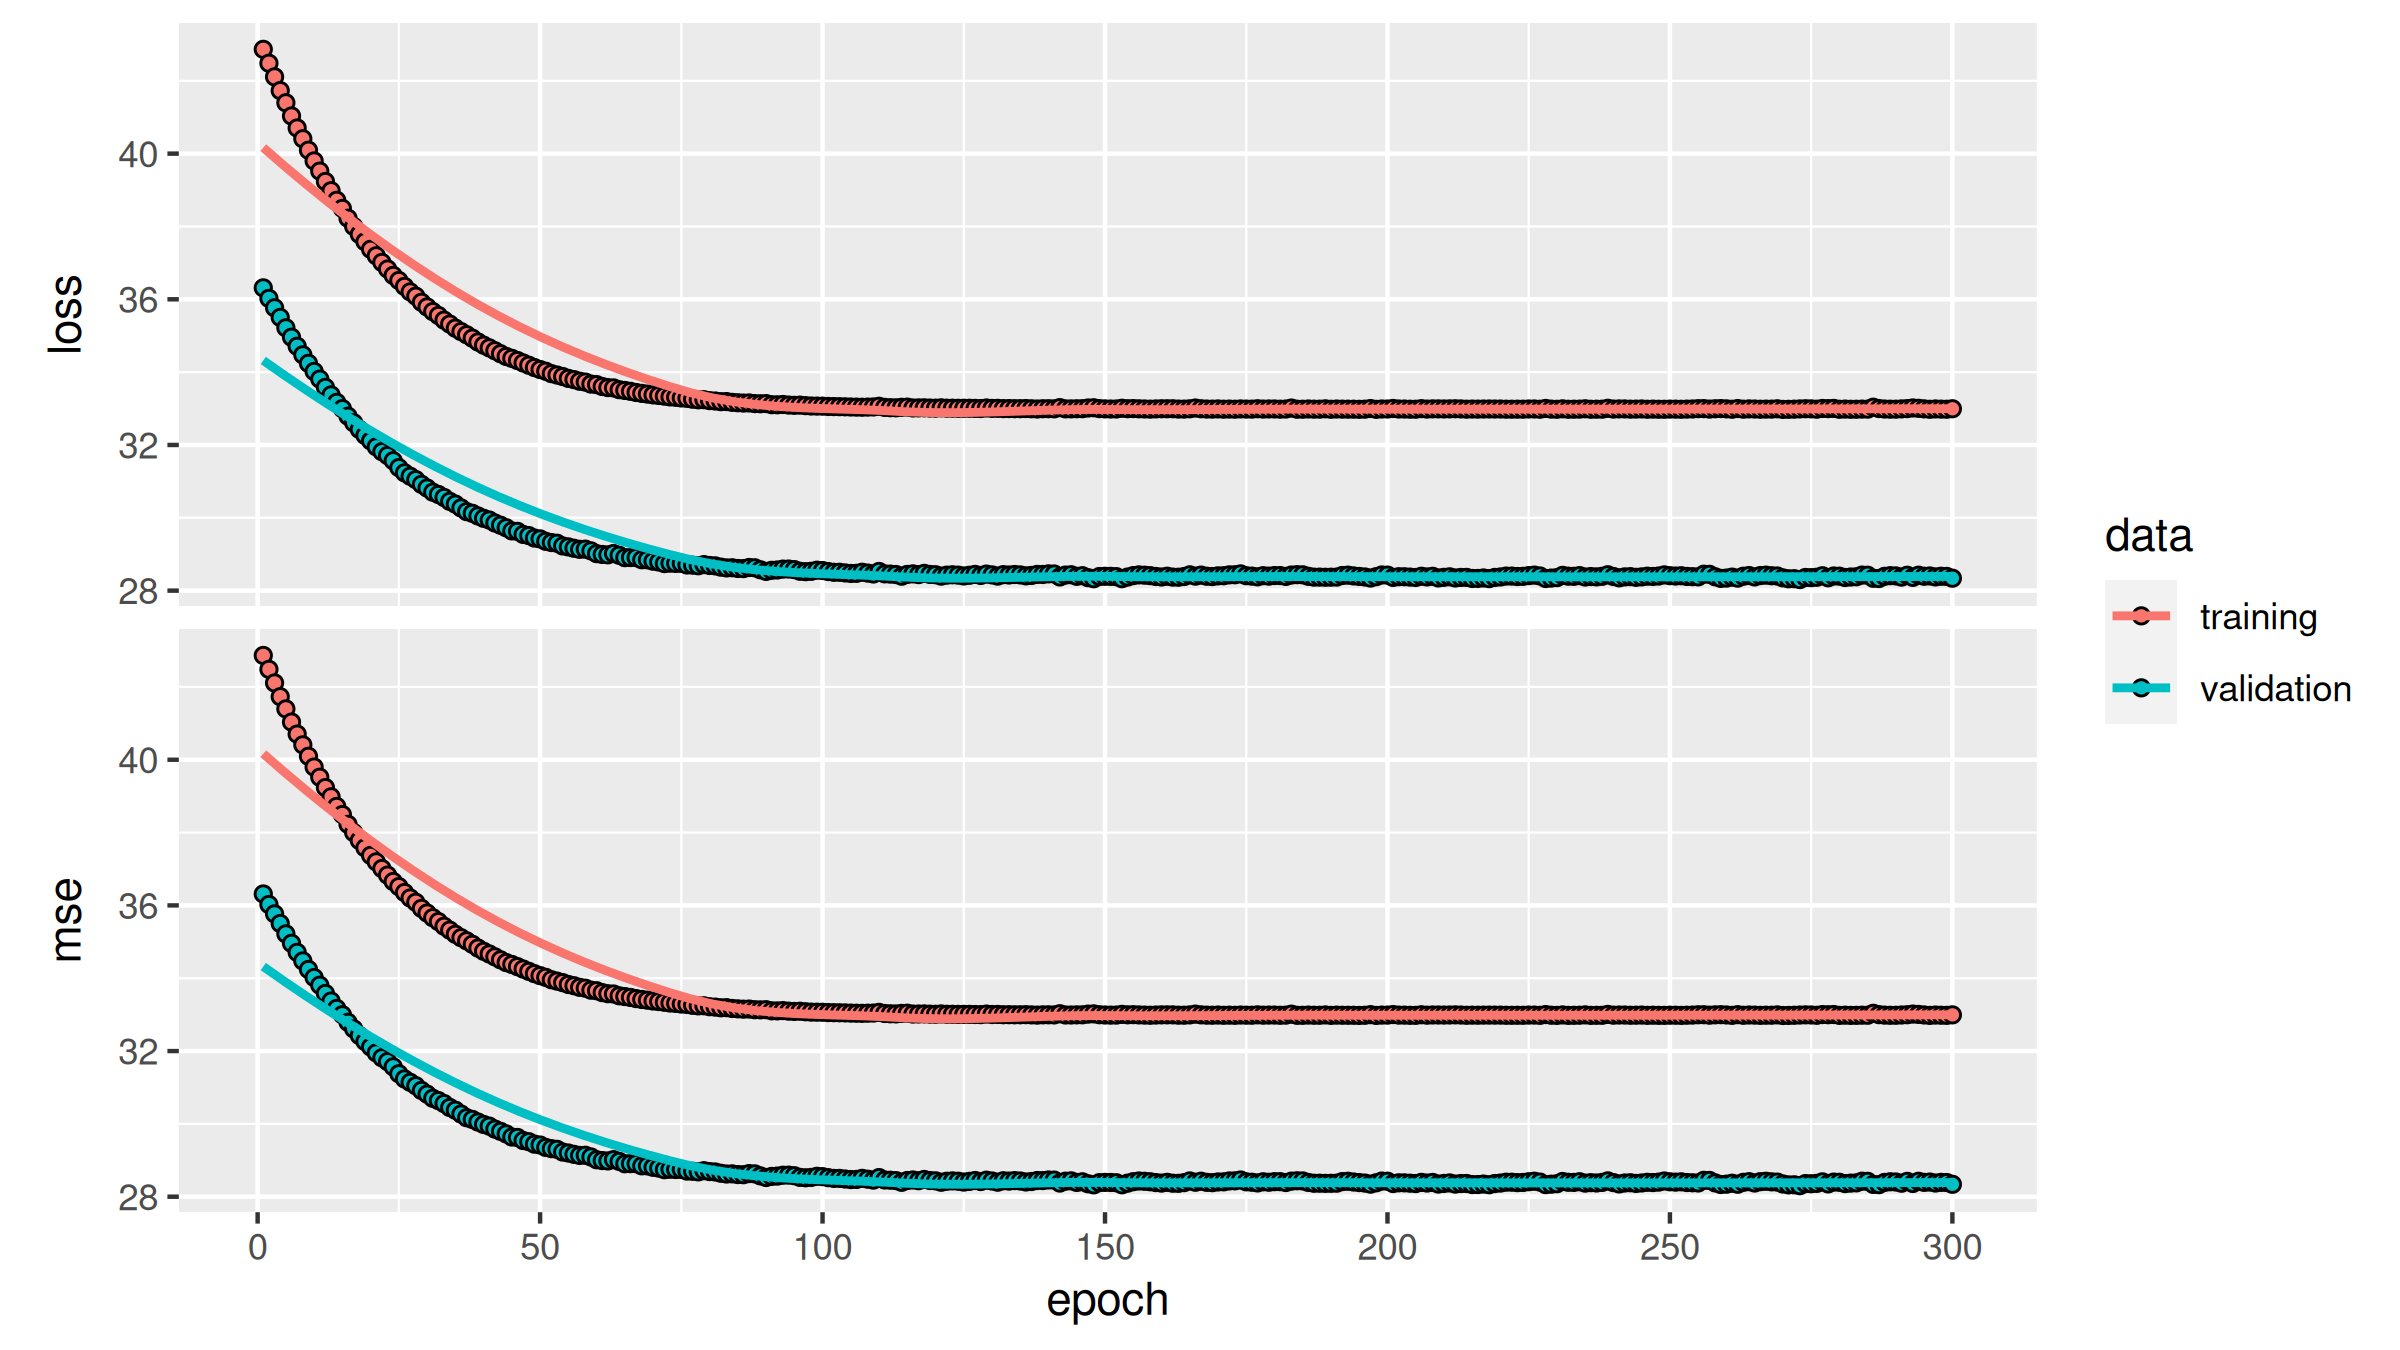

In [15]:
plot(trained_model)

In [16]:
evaluate(model1,X_train,y_train)

loss      mse 
32.50555 32.50555

In [17]:
model1$weights

[[1]]
<tf.Variable 'dense/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.00699441],
       [ 0.4595389 ],
       [ 0.39552727]], dtype=float32)>

[[2]]
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.00470513], dtype=float32)>


In [18]:
arima(x_train,order = c(3,0,0), method="CSS")


Call:
arima(x = x_train, order = c(3, 0, 0), method = "CSS")

Coefficients:
         ar1     ar2      ar3  intercept
      0.3918  0.4613  -0.0003     0.0569
s.e.  0.0490  0.0476   0.0492     1.9005

sigma^2 estimated as 32.5:  part log likelihood = -1314.39

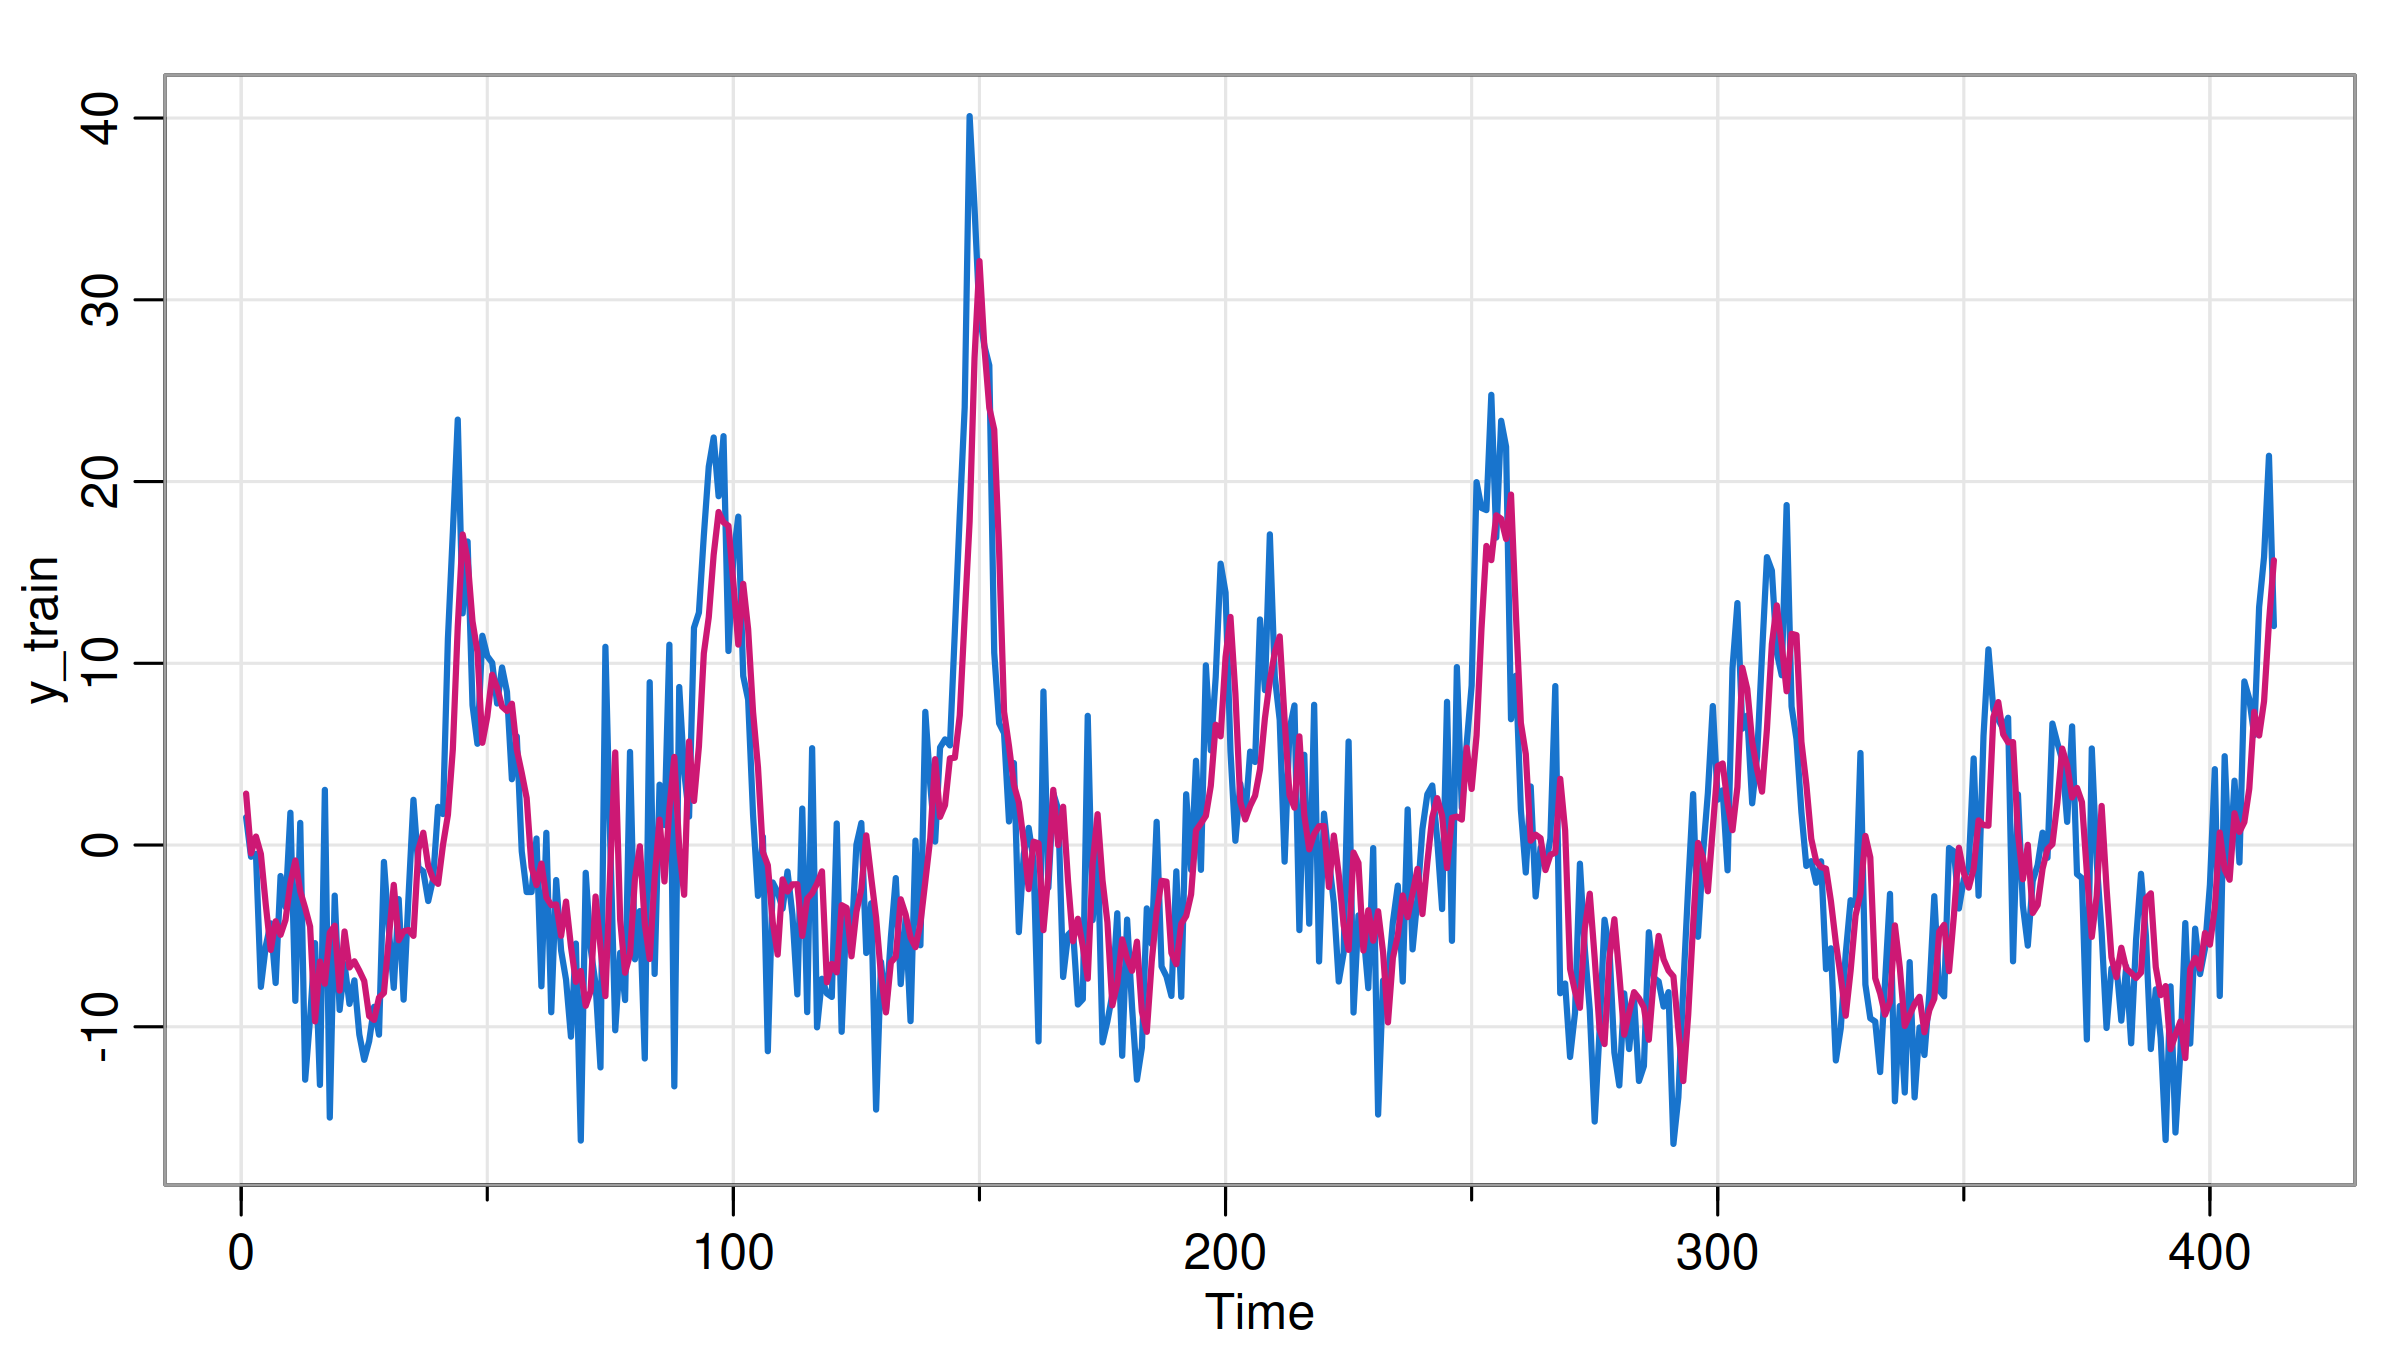

In [19]:
y1 = predict(model1,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y1, col=6, lwd=2)

## Modelo 2: múltiples capas densas

Agreguemos algunas capas para darle no linealidad al modelo. Usamos como función de activación `relu`, es decir $a(x)=\max\{x,0\}$.

In [20]:
# initialize our model
model2 <- keras_model_sequential()

model2 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units=32, activation='relu') %>%
    layer_dense(units = 1)

In [21]:
summary(model2)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 flatten_1 (Flatten)                (None, 3)                       0           
 dense_2 (Dense)                    (None, 32)                      128         
 dense_1 (Dense)                    (None, 1)                       33          
Total params: 161
Trainable params: 161
Non-trainable params: 0
________________________________________________________________________________


In [22]:
model2 %>% compile(loss = 'mse', 
                  optimizer = 'adam',
                  metrics = c('mse'))

In [23]:
trained_model2 <- model2 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


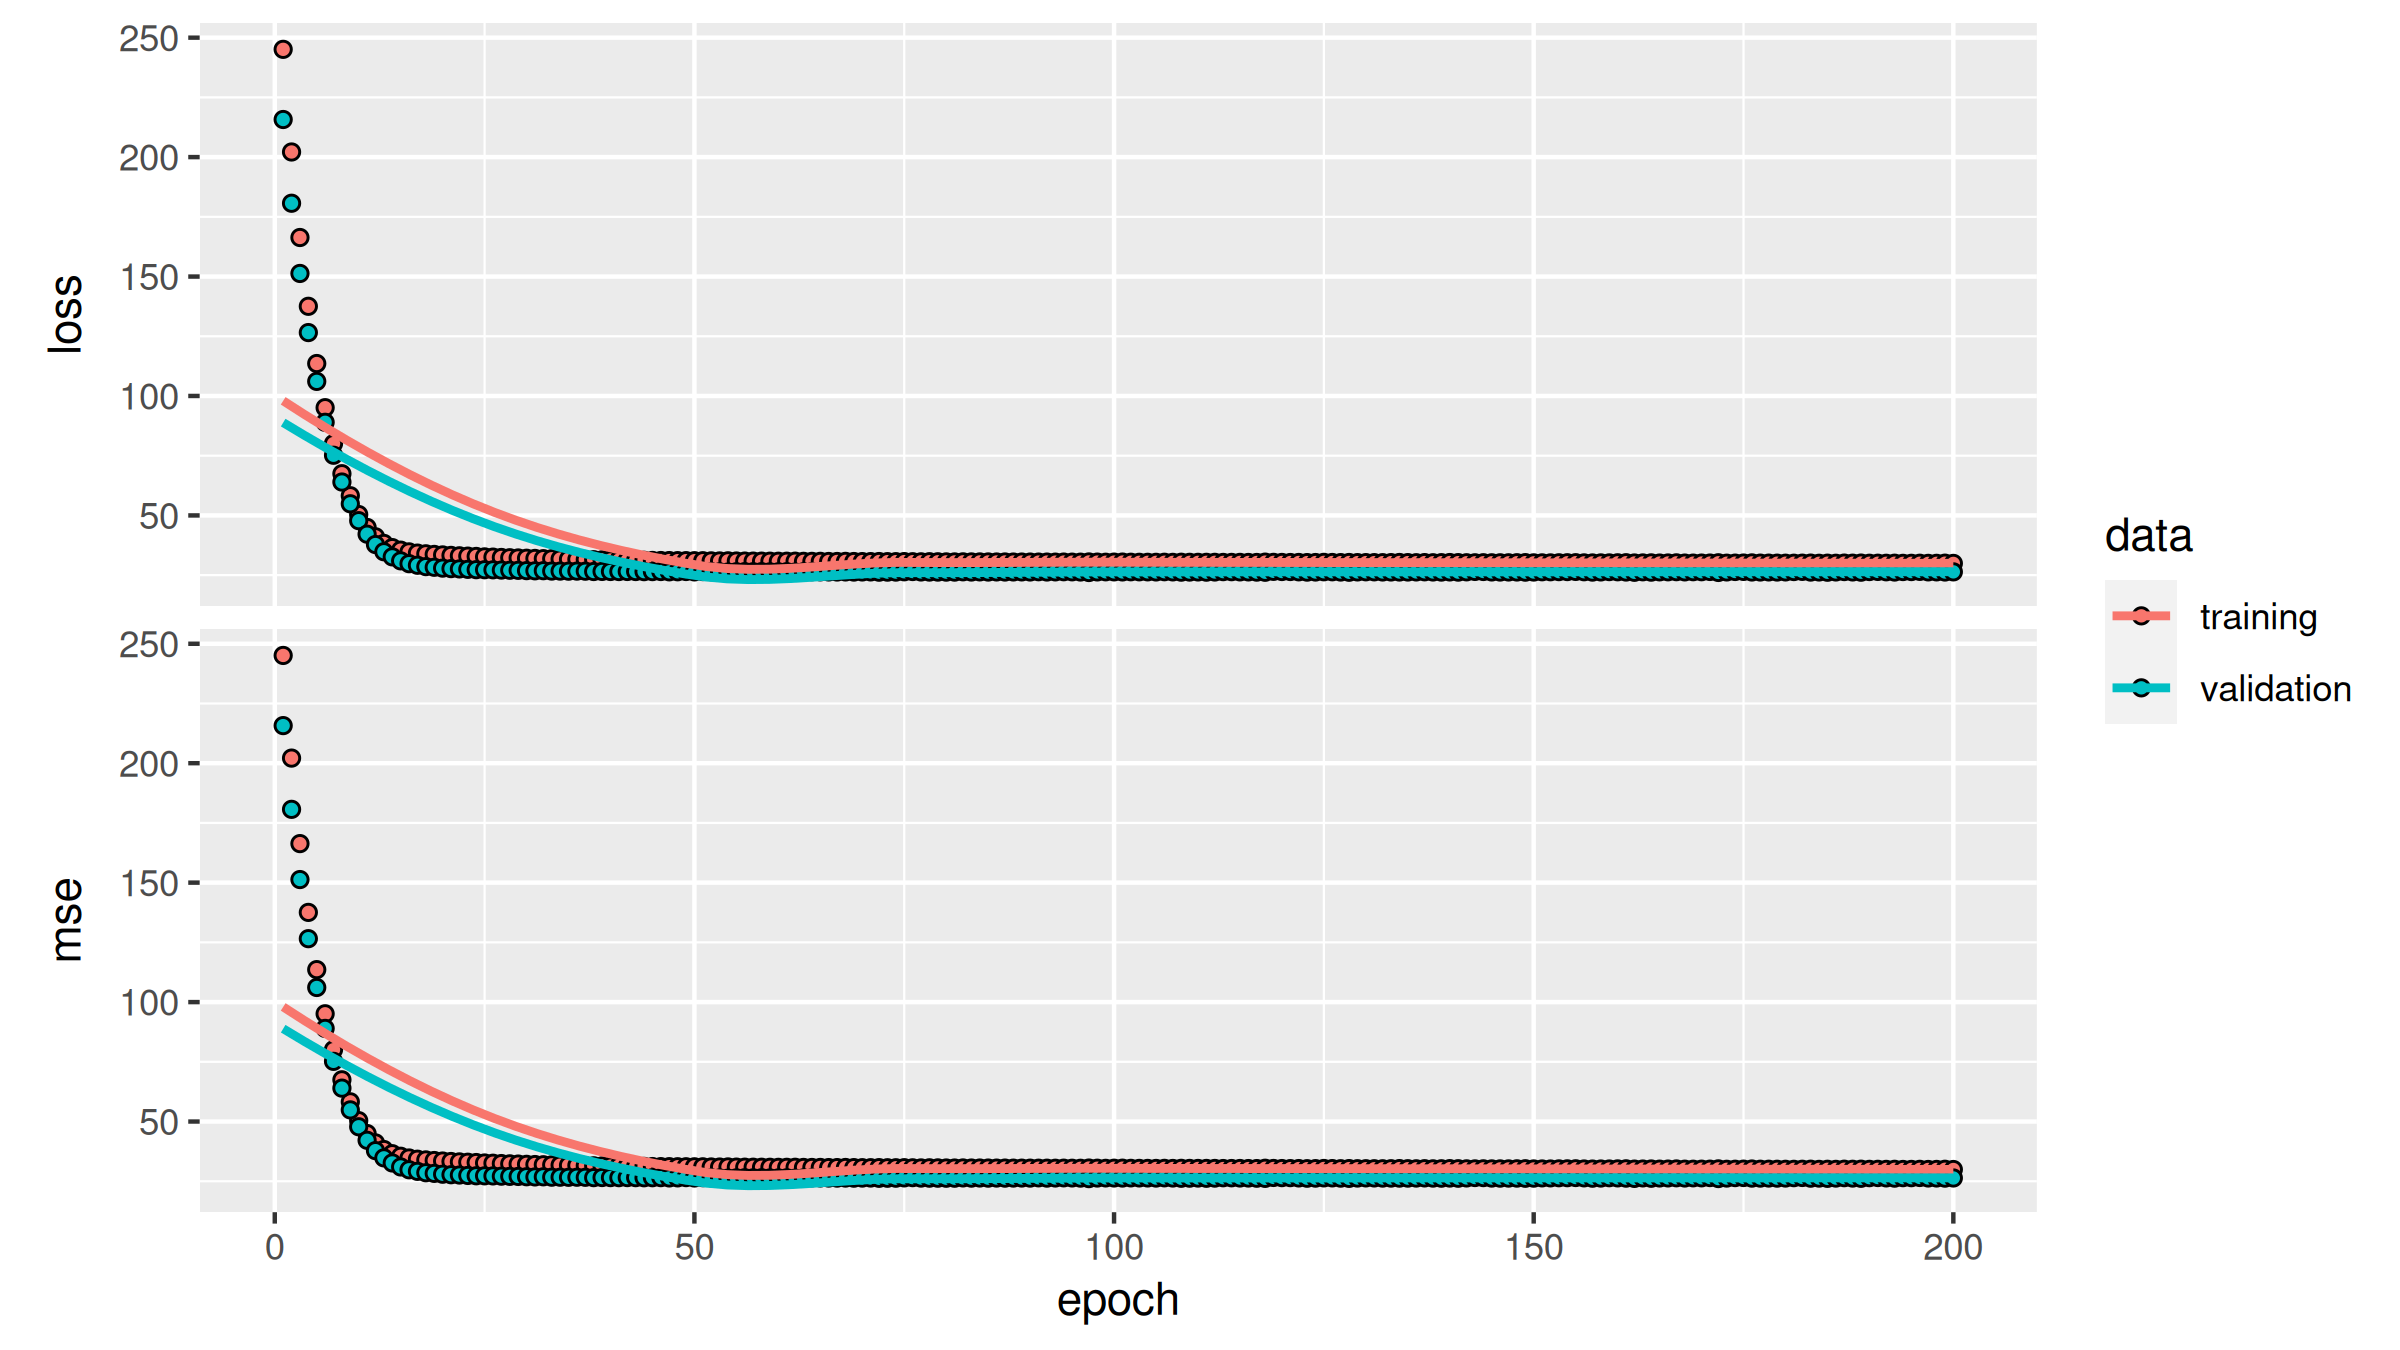

In [24]:
plot(trained_model2)

In [25]:
evaluate(model2,X_train,y_train)

loss      mse 
29.52019 29.52019

In [26]:
y2 = predict(model2,X_train)

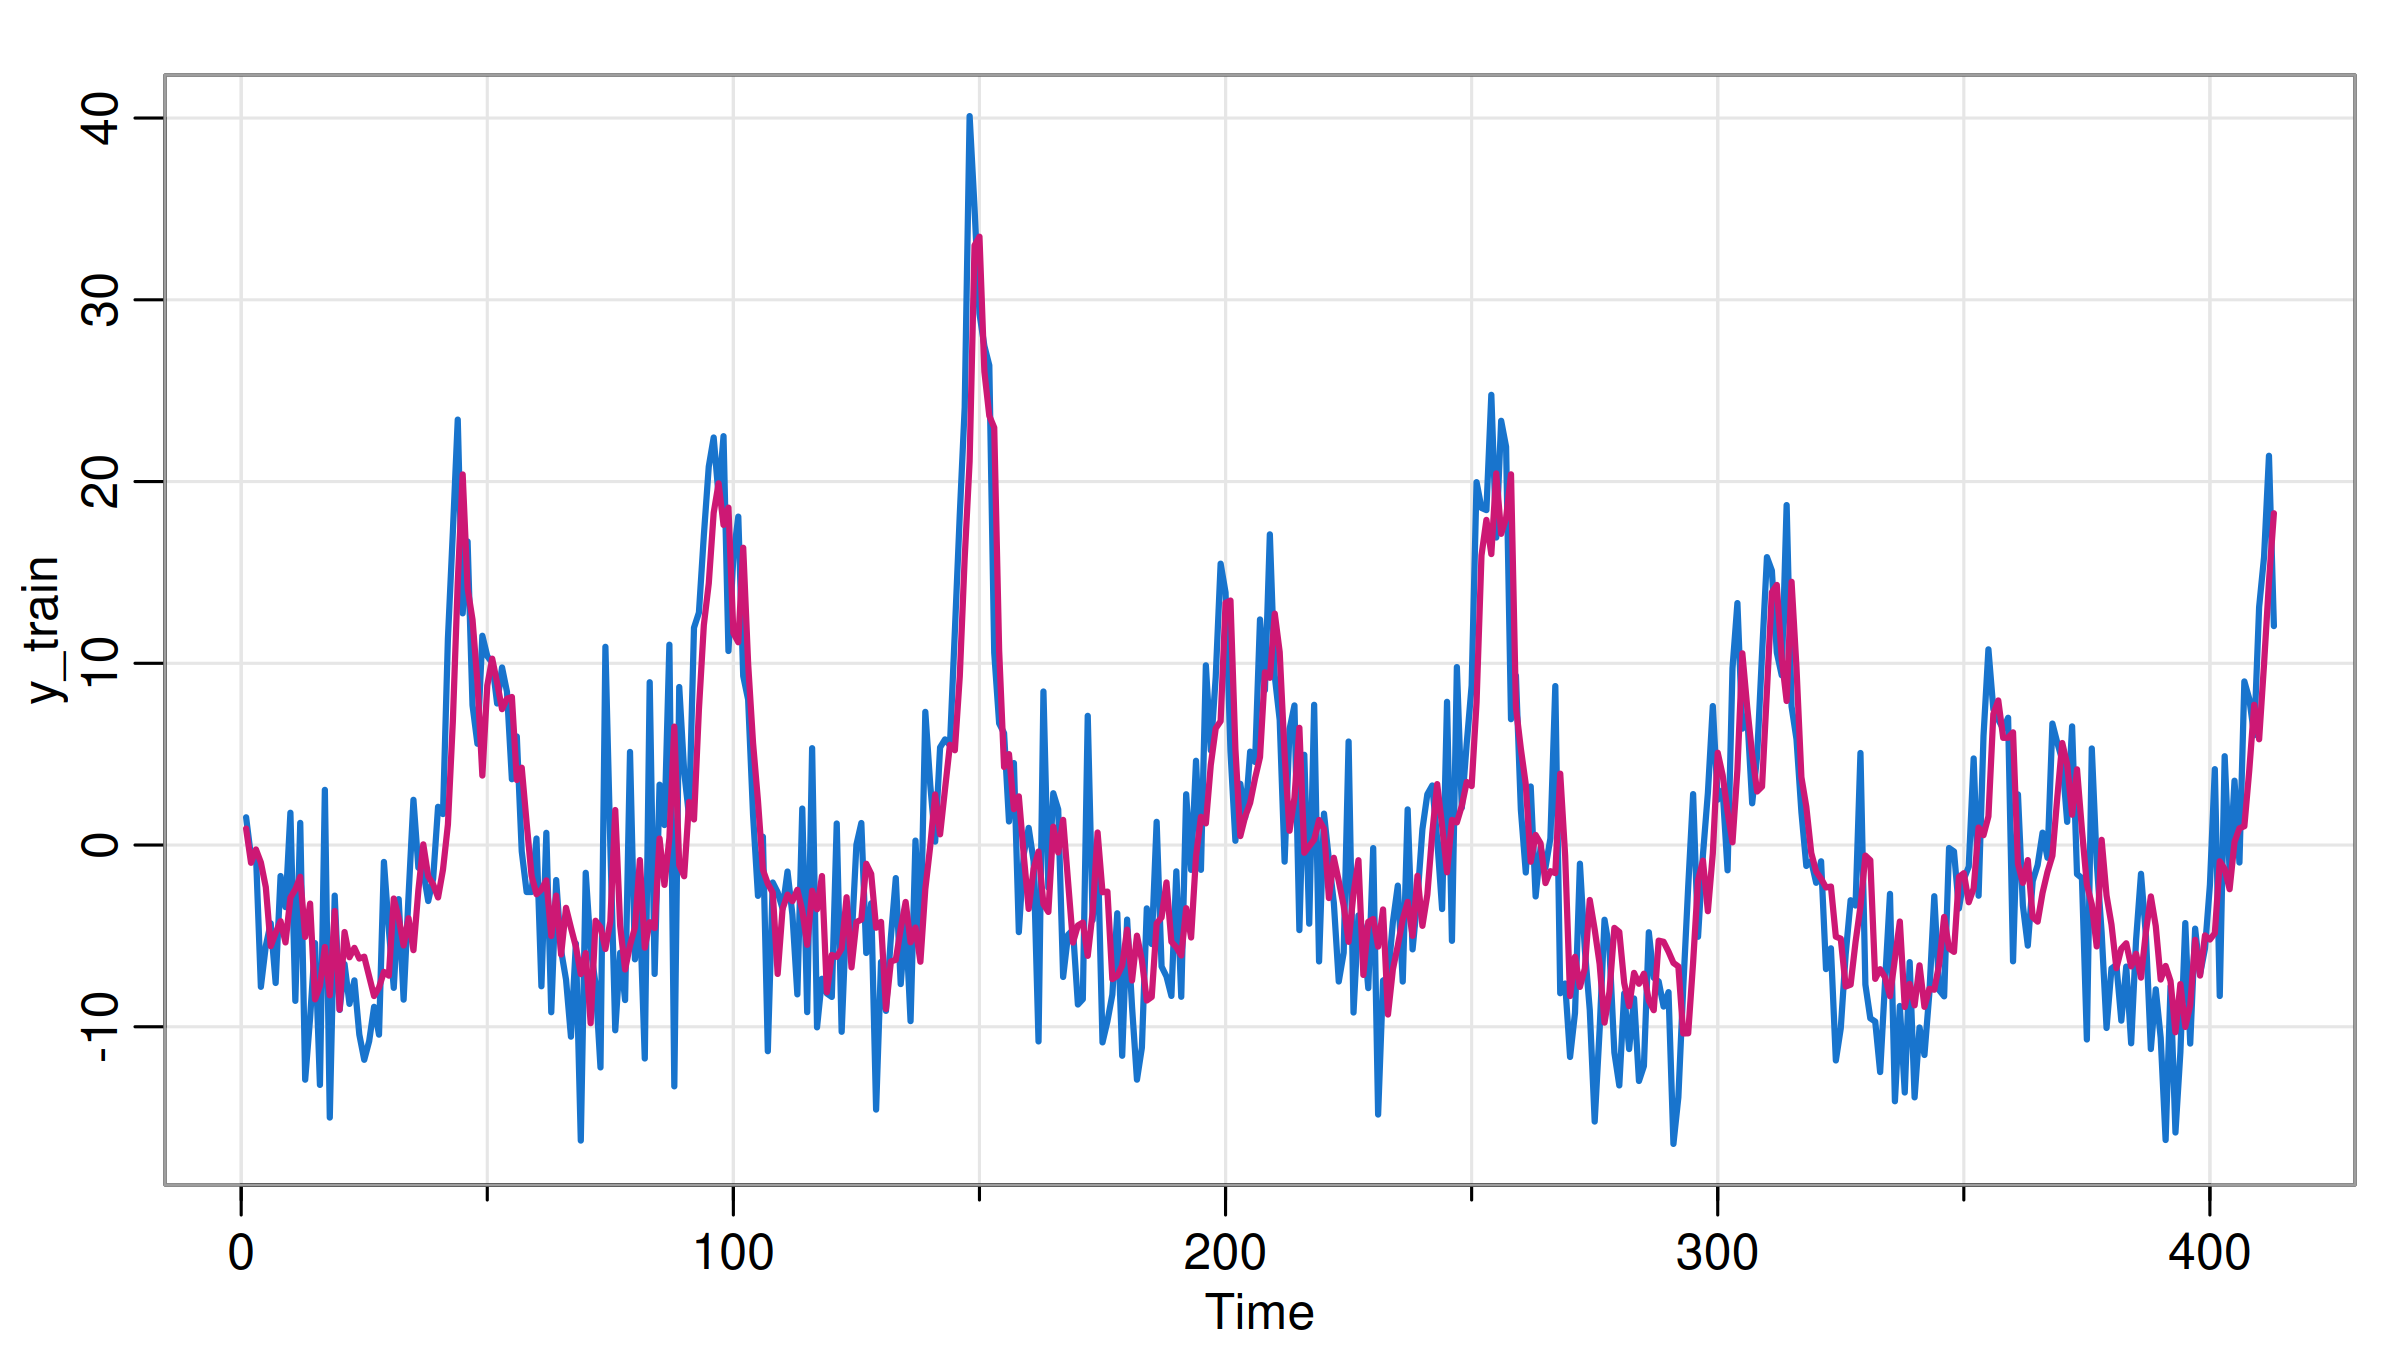

In [27]:
tsplot(y_train, col=4, lwd=2)
lines(y2, col=6, lwd=2)

## Modelo 3: agregando características

Agreguemos ahora al conjunto de entrenamiento algunas funciones del tiempo. Por ejemplo, el momento del año usando $\sin$ y $\cos$ como antes

### Preprocesamiento

In [28]:
window=3
pred = 1
x_train = x[time(x)<1978]
sint = sin(2*pi*time(x))
cost = cos(2*pi*time(x))

n=length(x_train)

X_train = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_train = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_train[i,,1] = x_train[i:(i+window-1)]
    X_train[i,,2] = sint[i:(i+window-1)]
    X_train[i,,3] = cost[i:(i+window-1)]
    y_train[i,] = x_train[(i+window):(i+window+pred-1)]
}
dim(X_train)
dim(y_train)

[1] 413   3   3

[1] 413   1

### Ajuste

In [29]:
# initialize our model
model3 <- keras_model_sequential()

model3 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 1)

In [30]:
summary(model3)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 flatten_2 (Flatten)                (None, 9)                       0           
 dense_3 (Dense)                    (None, 1)                       10          
Total params: 10
Trainable params: 10
Non-trainable params: 0
________________________________________________________________________________


In [31]:
model3 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [32]:
trained_model3 <- model3 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


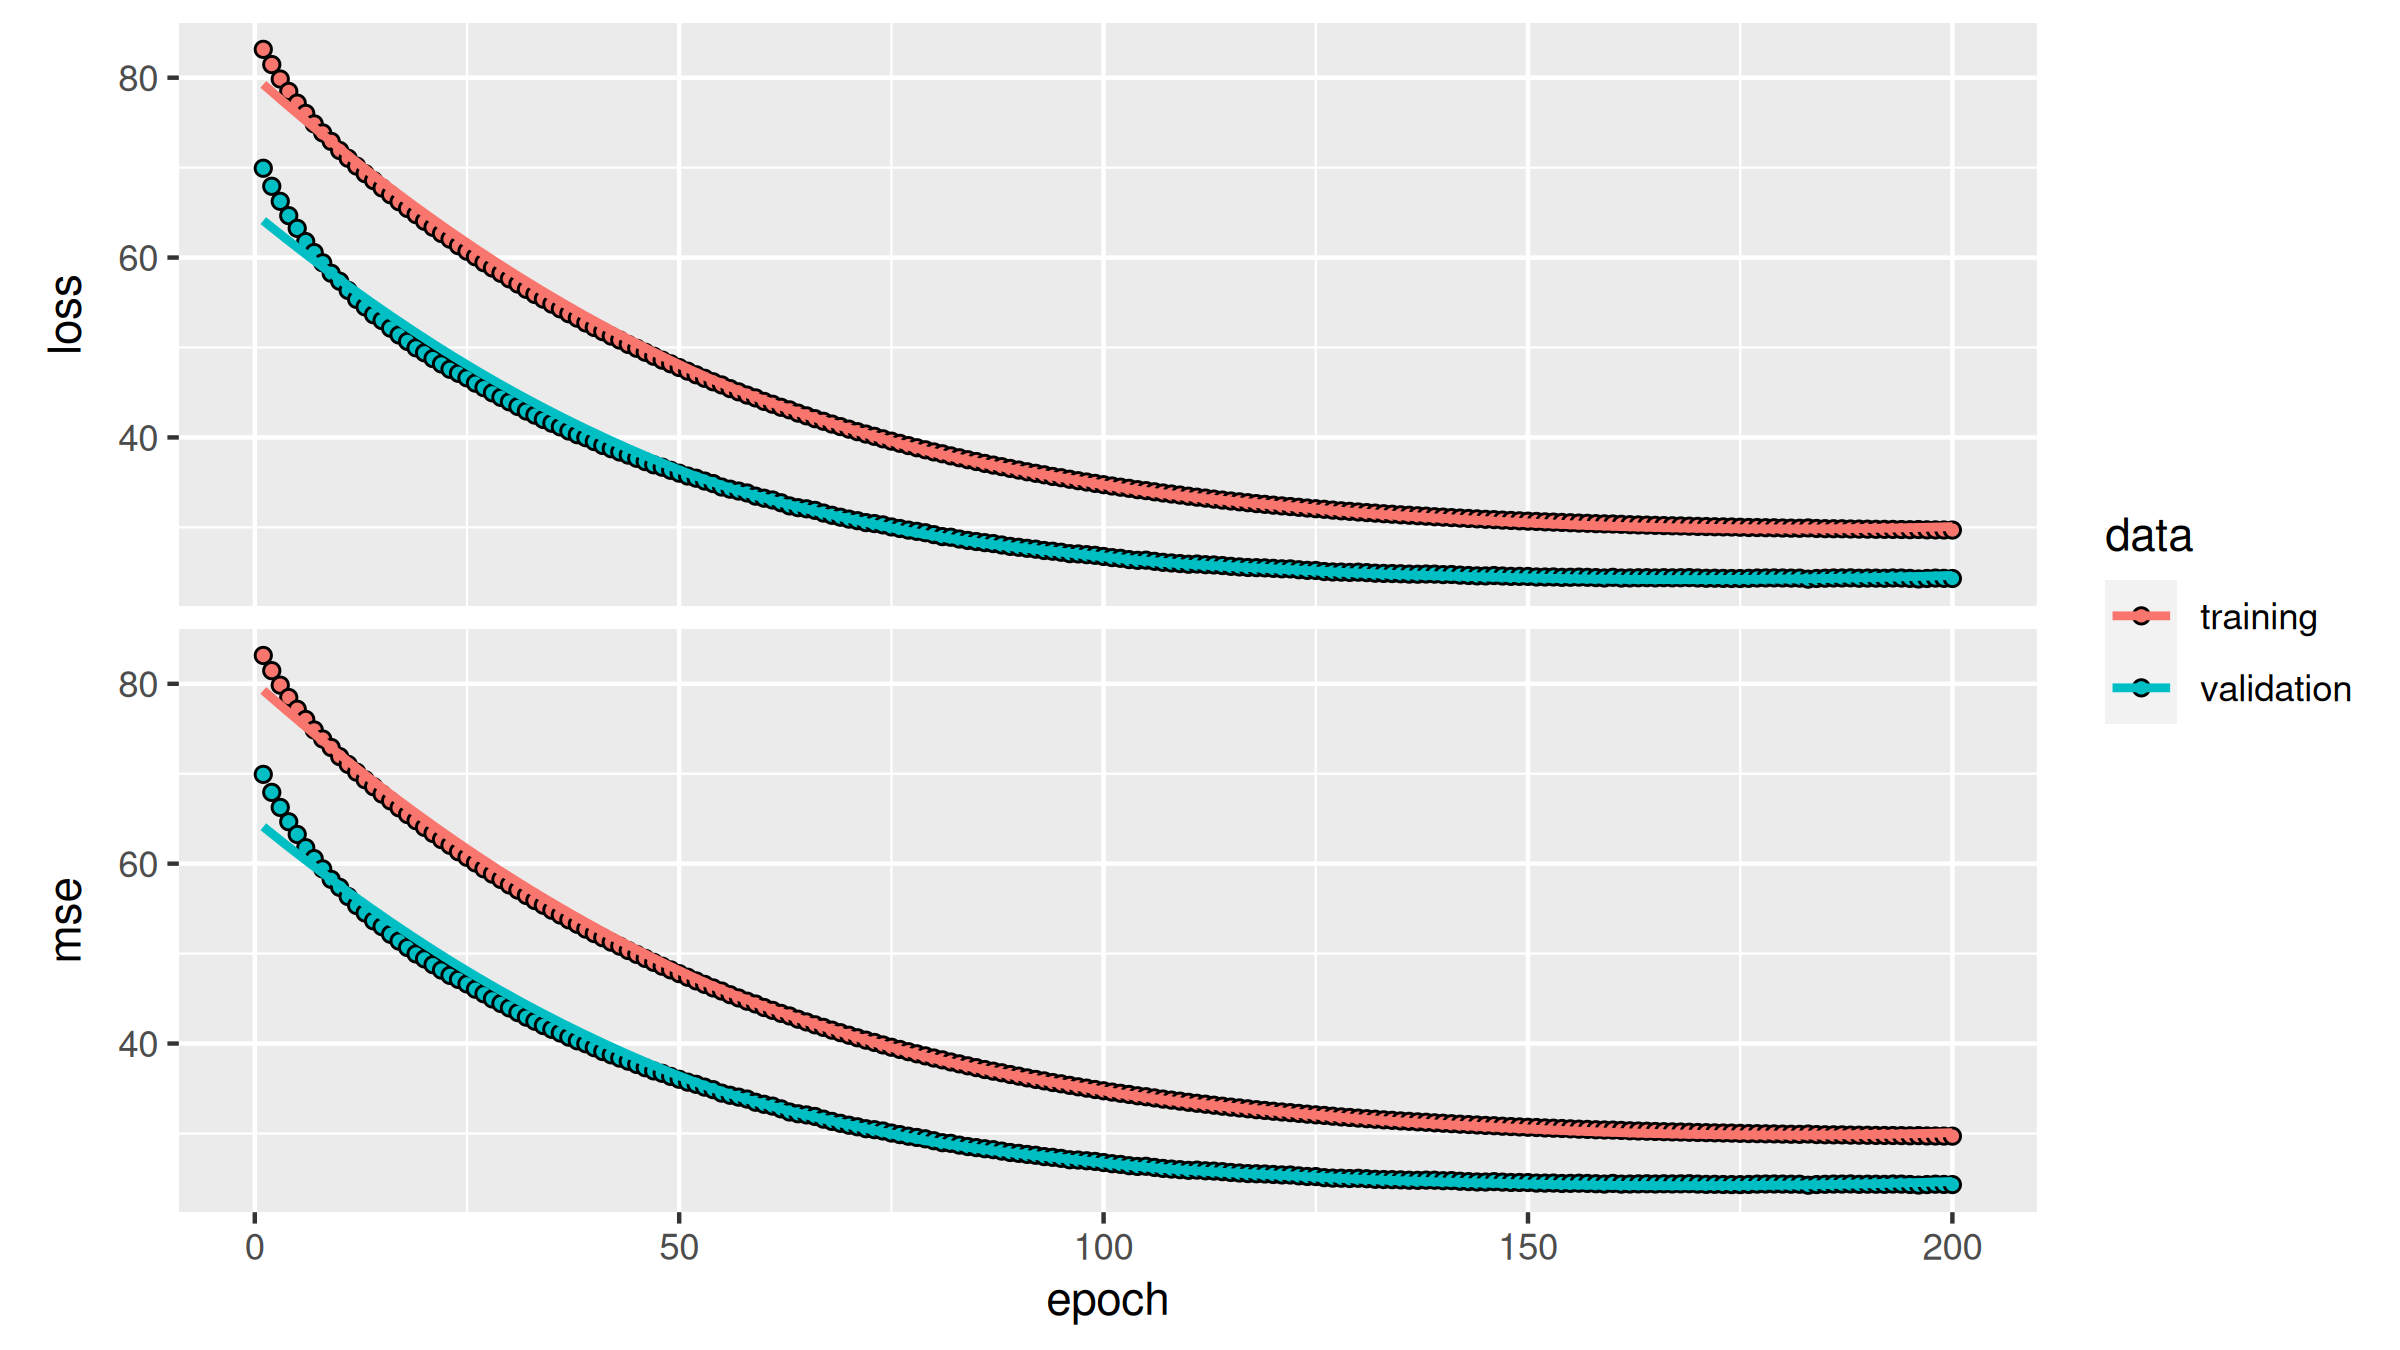

In [33]:
plot(trained_model3)

In [34]:
model3$weights

[[1]]
<tf.Variable 'dense_3/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.02453164],
       [-1.3066391 ],
       [ 0.8739636 ],
       [ 0.43012777],
       [-0.5821313 ],
       [ 0.49267697],
       [ 0.24024566],
       [-0.85056704],
       [-0.00794684]], dtype=float32)>

[[2]]
<tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32, numpy=array([0.00347056], dtype=float32)>


In [35]:
evaluate(model3, X_train, y_train)

loss      mse 
29.14749 29.14749

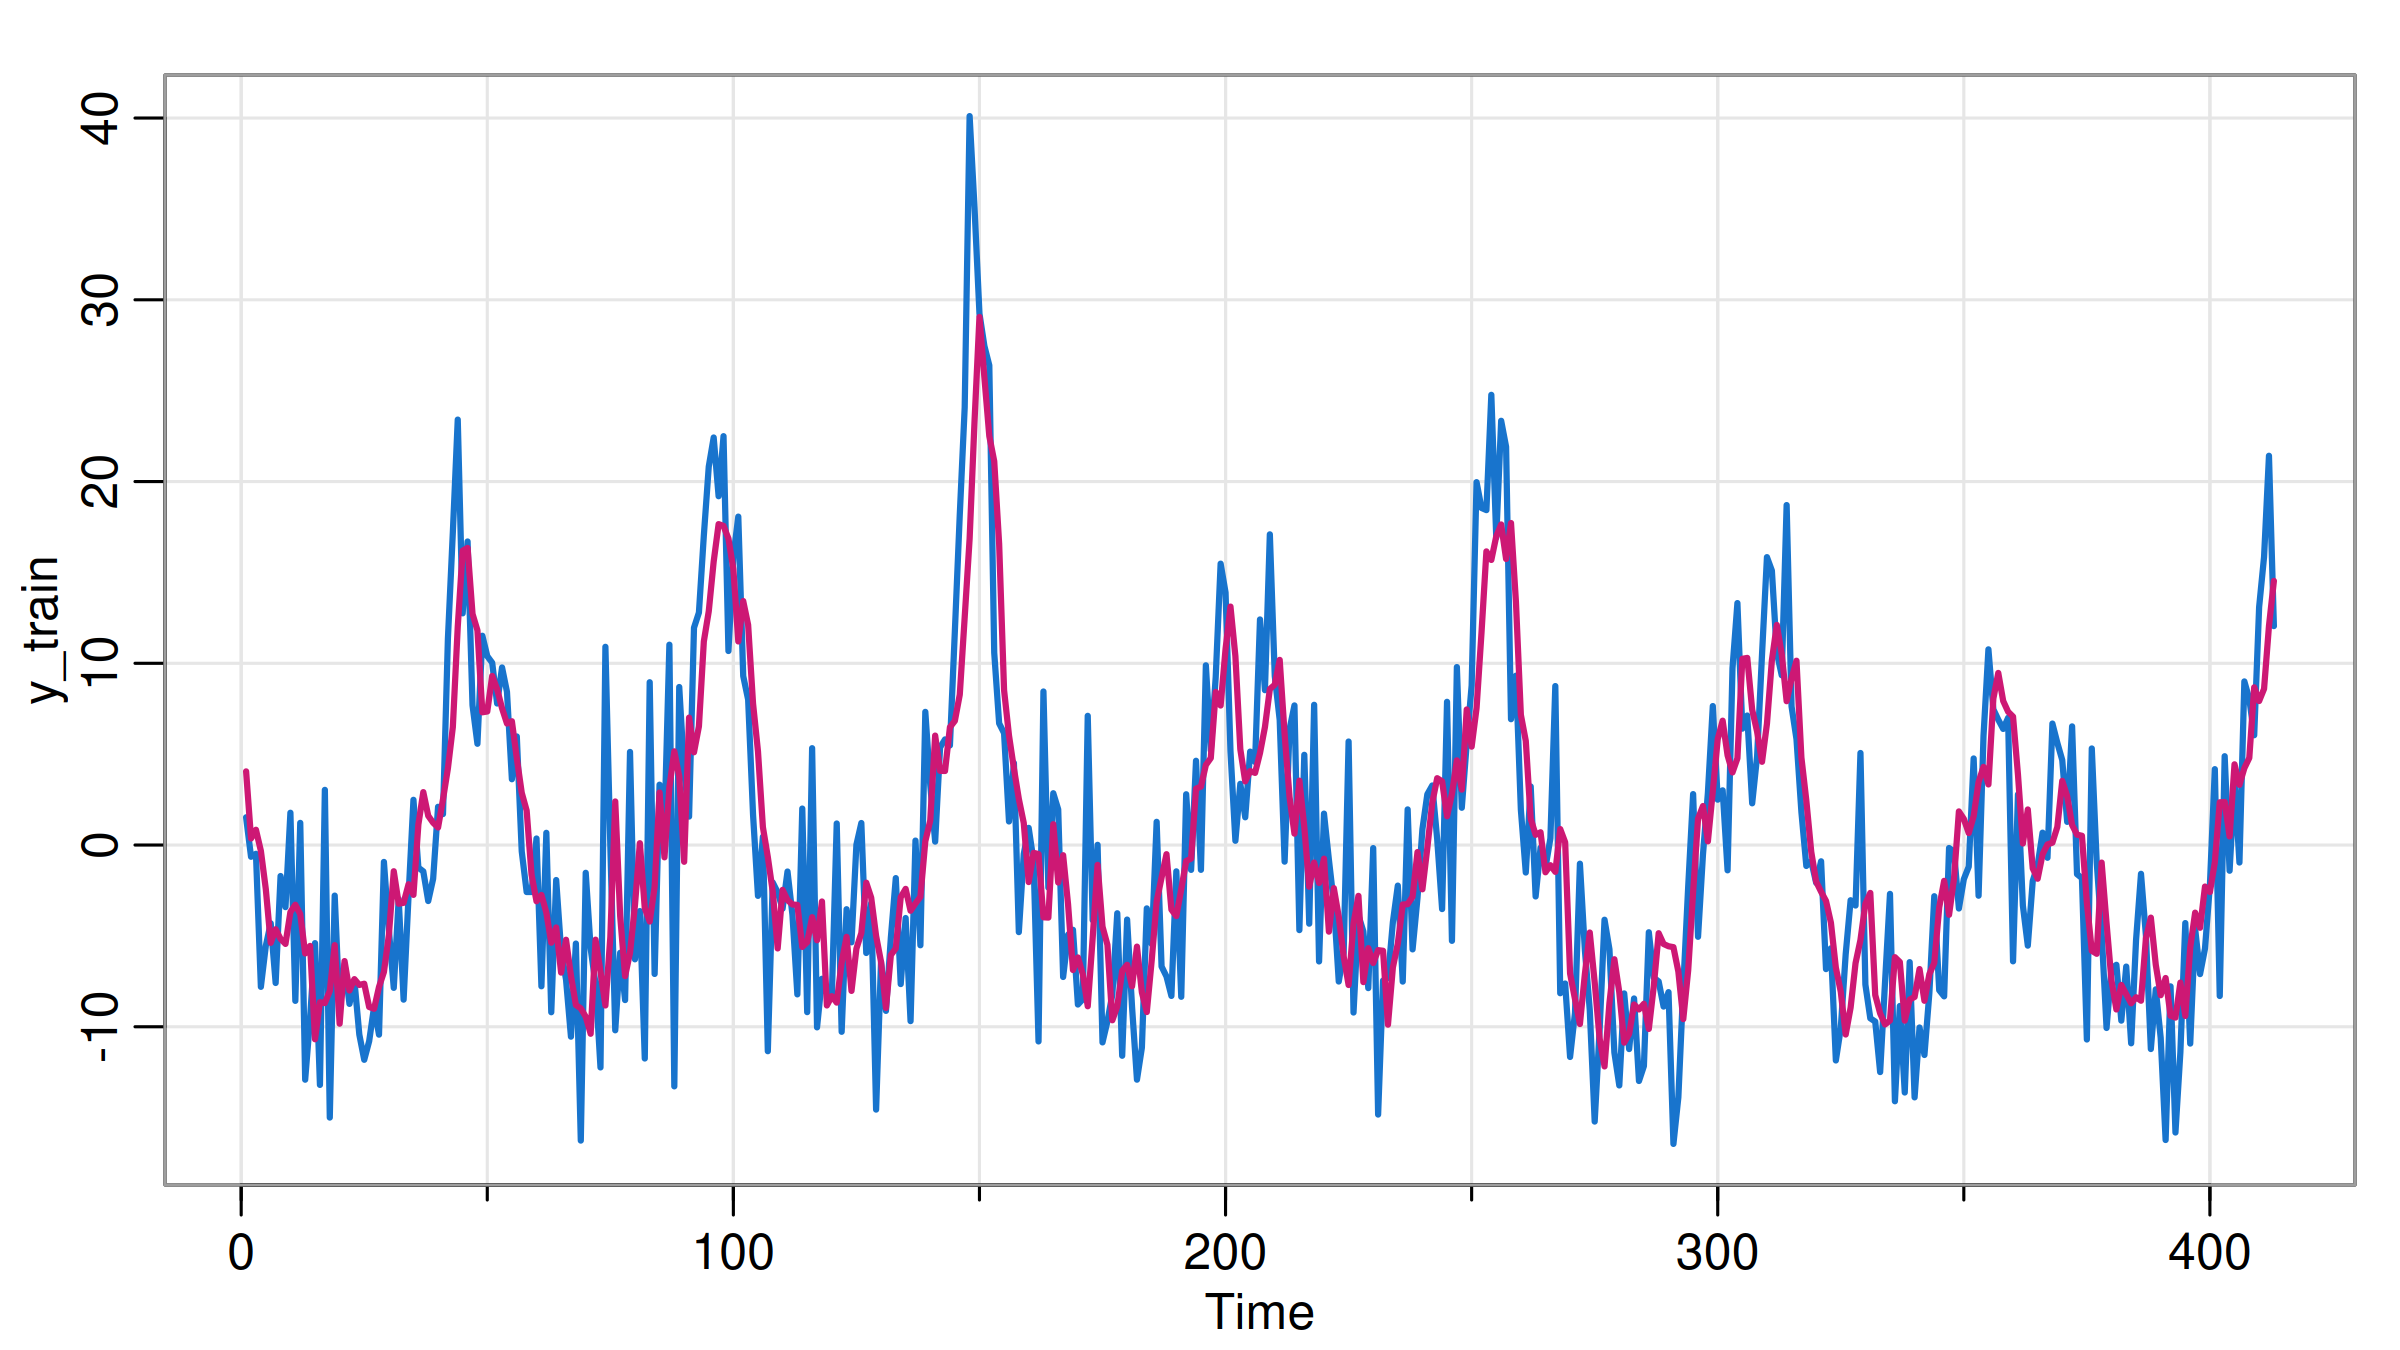

In [36]:
y3 = predict(model3,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y3, col=6, lwd=2)

## Modelo 4: características y capas

Agreguemos un par de capas densas intermedias

In [37]:
# initialize our model
model4 <- keras_model_sequential()

model4 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 32, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

In [38]:
summary(model4)

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 flatten_3 (Flatten)                (None, 9)                       0           
 dense_6 (Dense)                    (None, 32)                      320         
 dense_5 (Dense)                    (None, 16)                      528         
 dense_4 (Dense)                    (None, 1)                       17          
Total params: 865
Trainable params: 865
Non-trainable params: 0
________________________________________________________________________________


In [39]:
model4 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [40]:
trained_model4 <- model4 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


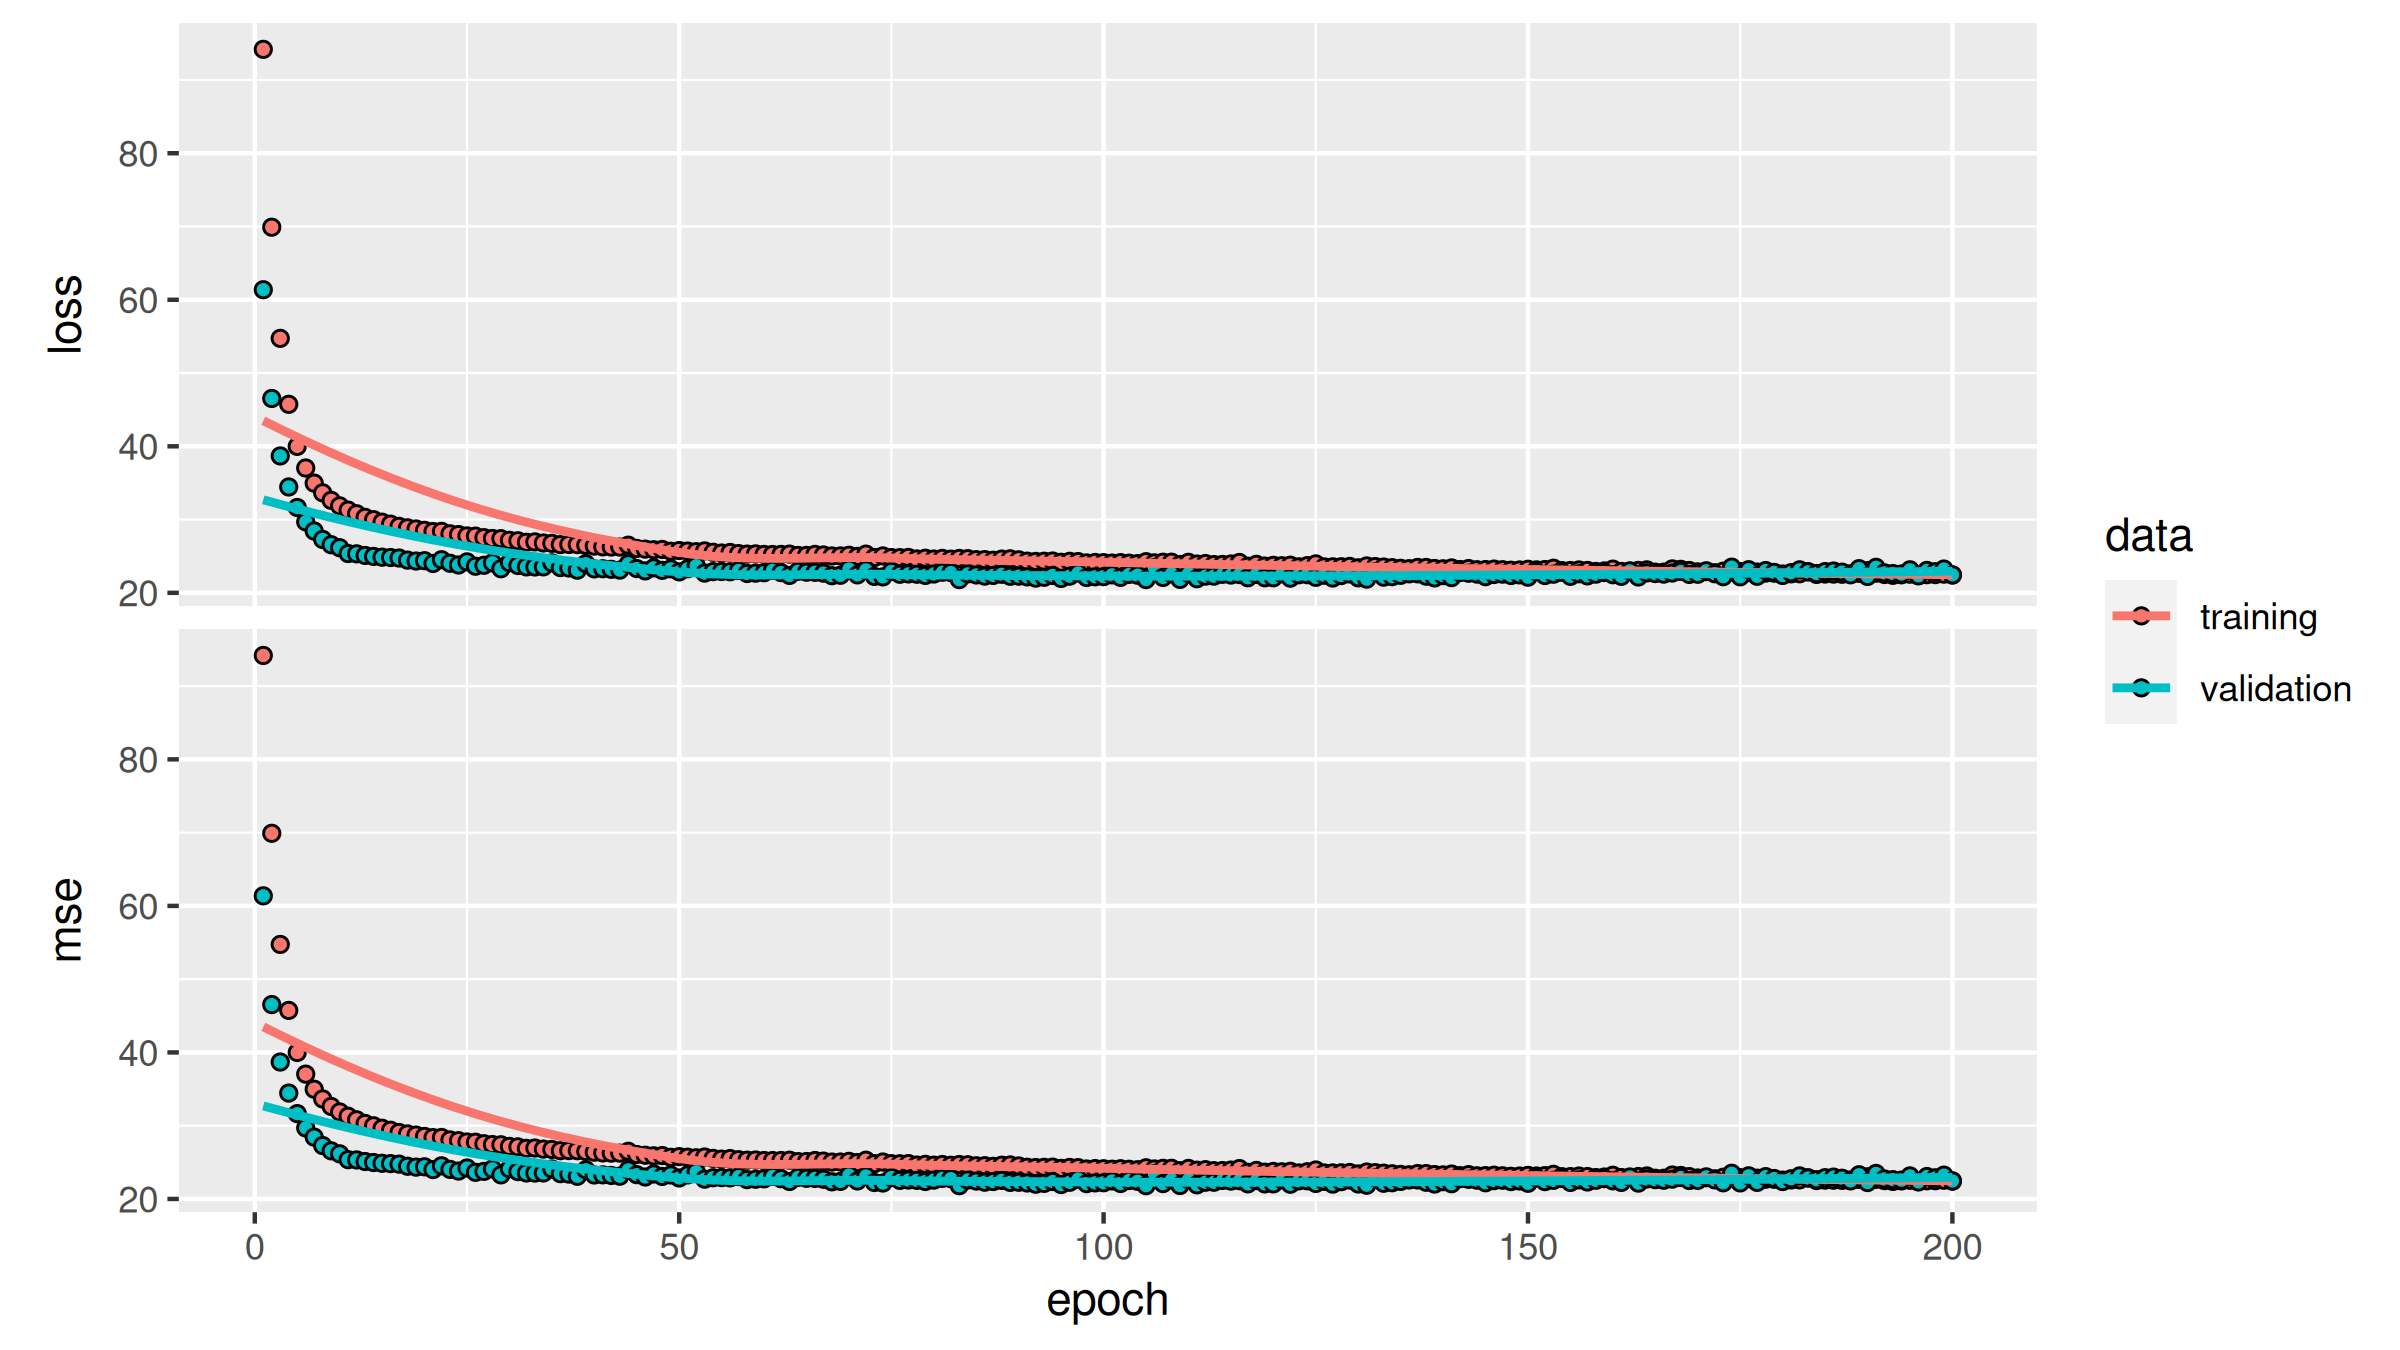

In [41]:
plot(trained_model4)

In [42]:
evaluate(model4, X_train, y_train)

loss      mse 
22.23892 22.23892

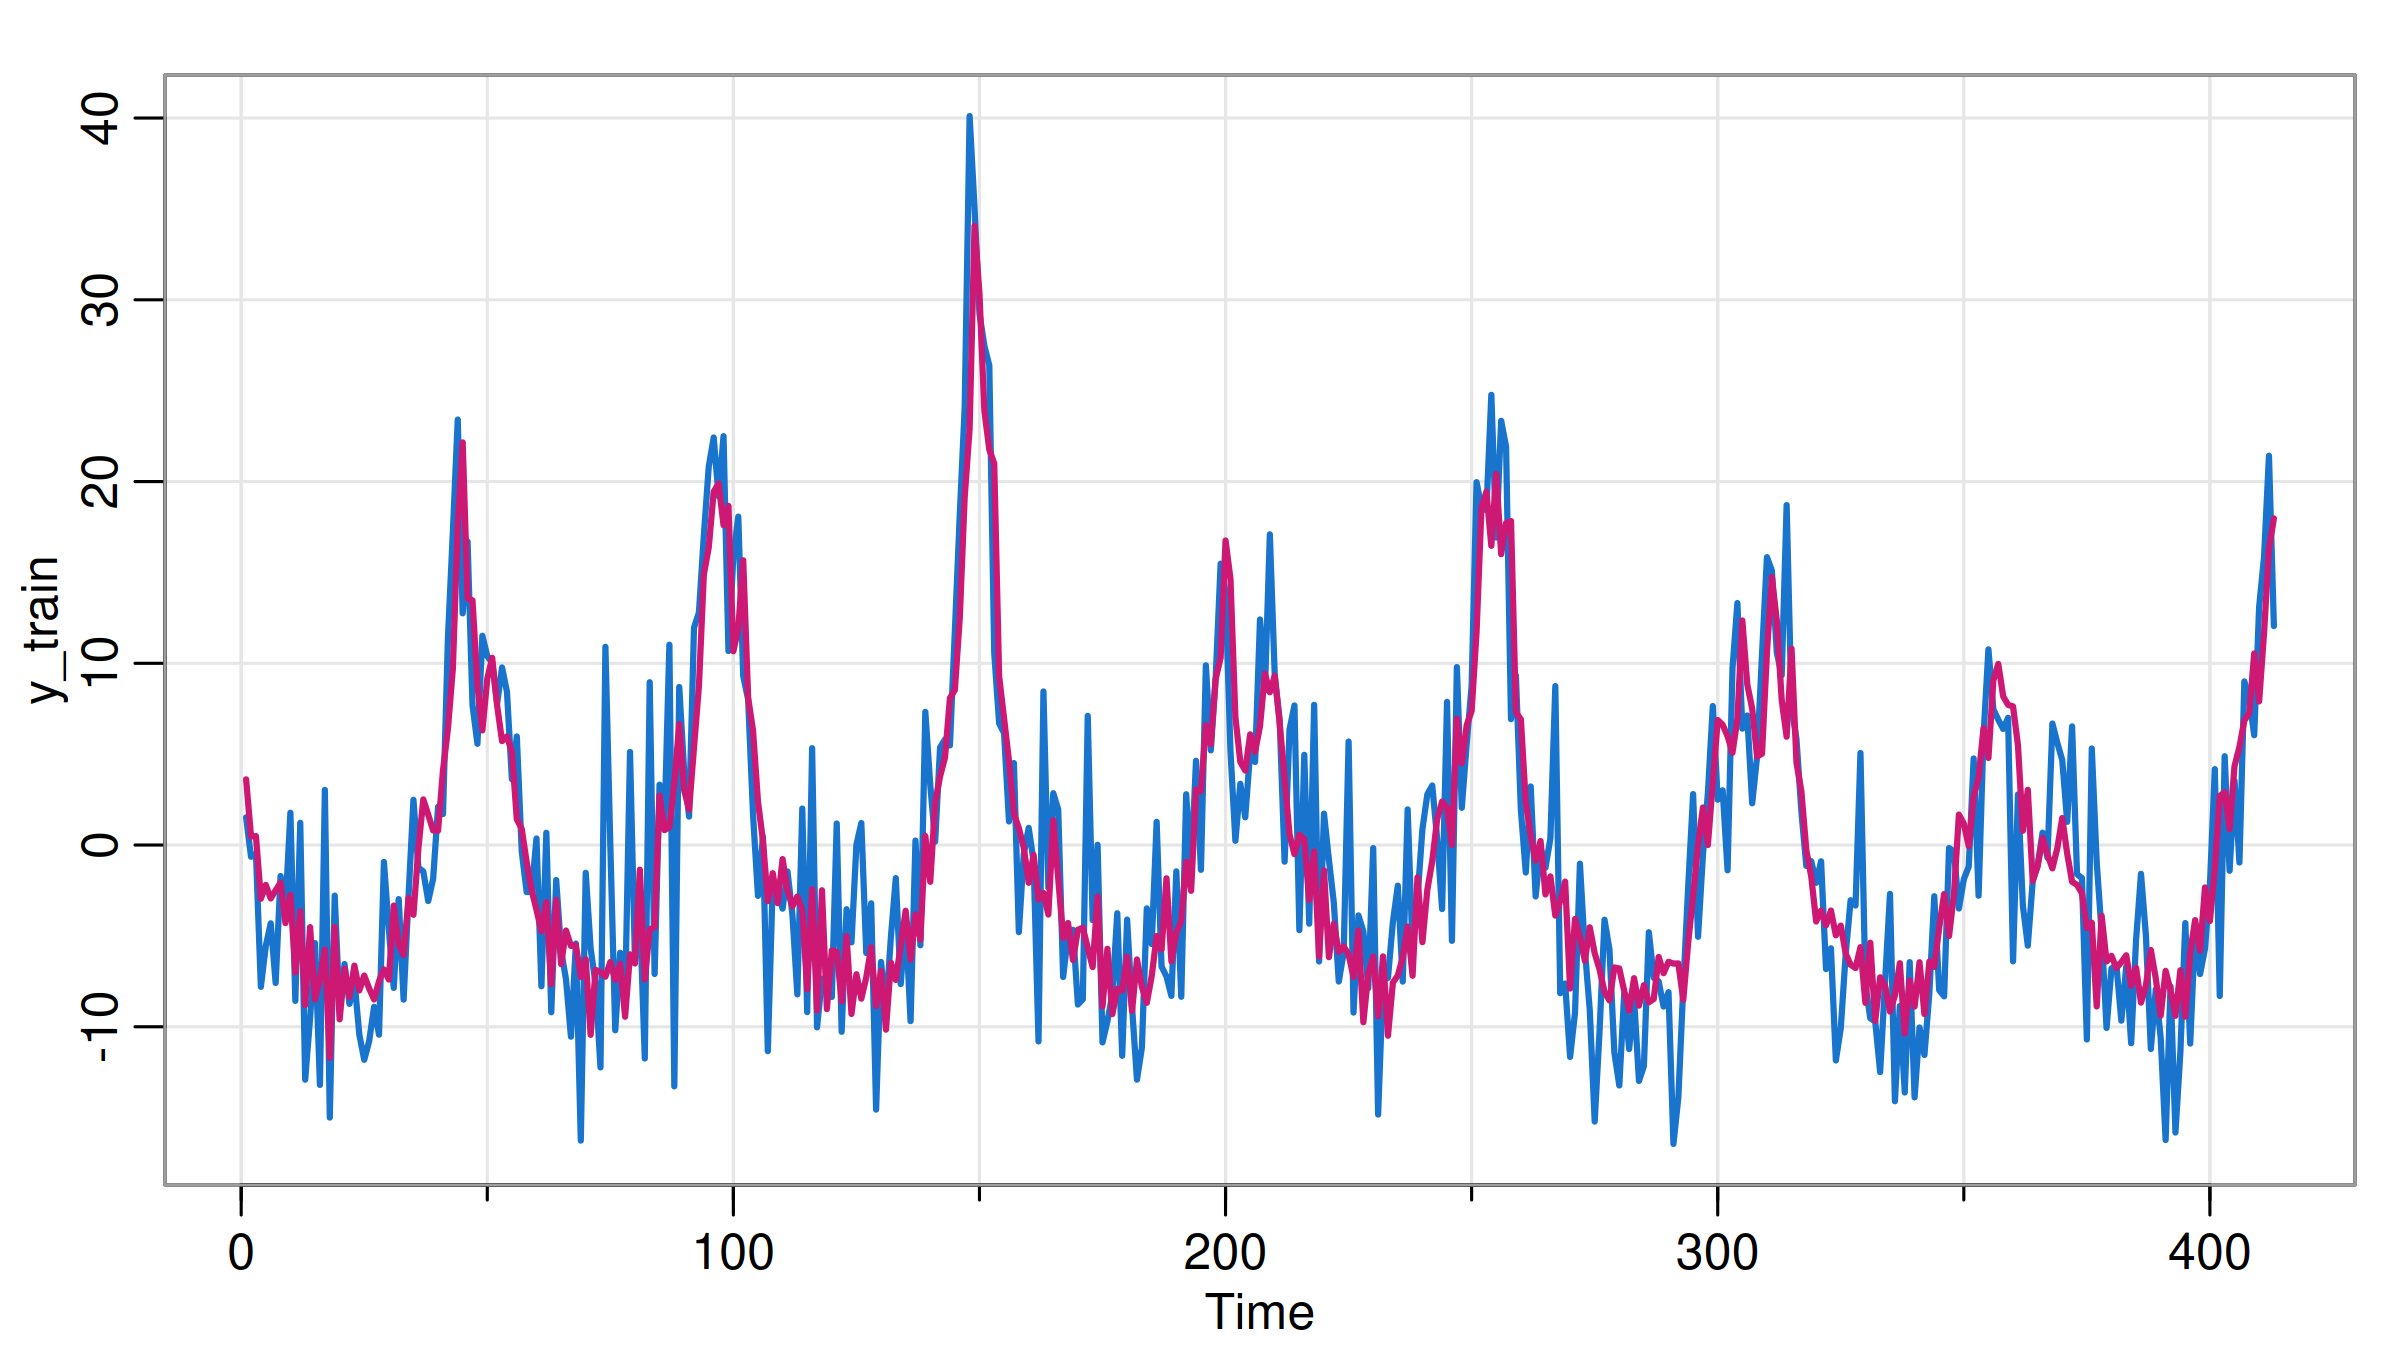

In [43]:
y4 = predict(model4,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y4, col=6, lwd=2)

## Modelo 5: Convolutional Neural Network

La idea de la capa convolucional o CNN es similar a la de los procesos autorregresivos y a lo que veníamos haciendo antes, solo que simplifica un poco la escritura del modelo. El de abajo es esencialmente el mismo modelo 4 pero usando CNNs.

![CNN](../images/cnn.png)

In [44]:
# initialize our model
model5 <- keras_model_sequential()

model5 %>%
    layer_conv_1d(input_shape = dim(X_train)[2:3], filters = 32, kernel_size=window, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

In [45]:
summary(model5)

Model: "sequential_4"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv1d (Conv1D)                    (None, 1, 32)                   320         
 dense_8 (Dense)                    (None, 1, 16)                   528         
 dense_7 (Dense)                    (None, 1, 1)                    17          
Total params: 865
Trainable params: 865
Non-trainable params: 0
________________________________________________________________________________


In [46]:
model5 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [47]:
trained_model5 <- model5 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


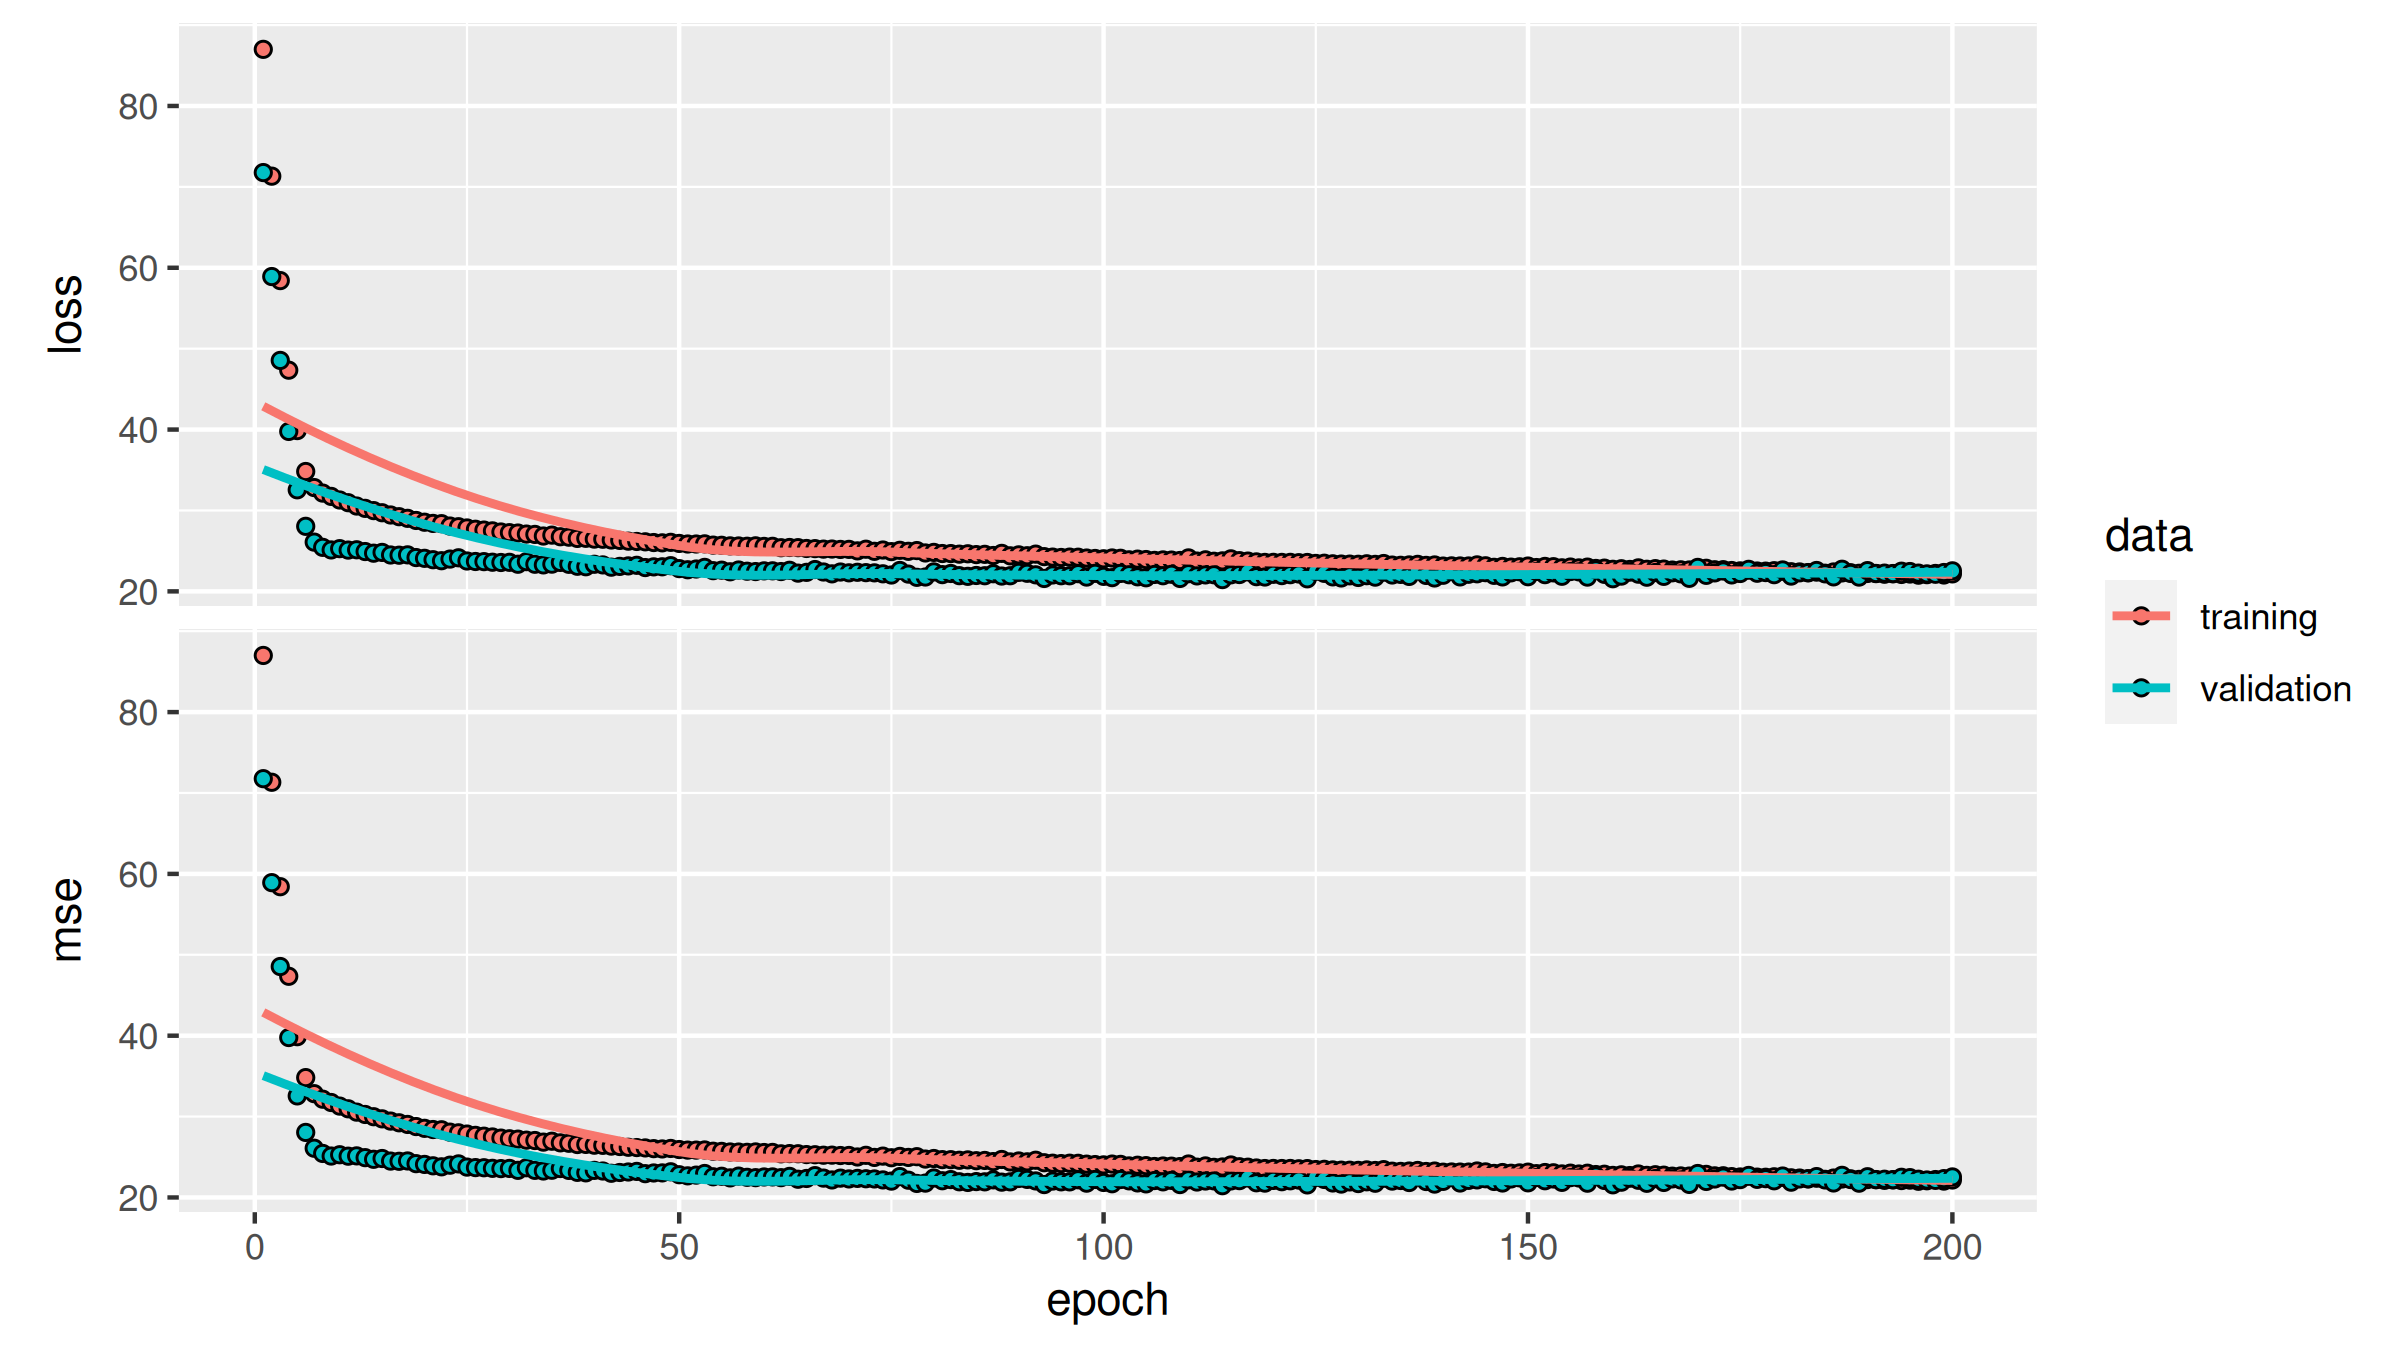

In [48]:
plot(trained_model5)

In [49]:
evaluate(model5, X_train, y_train)

loss      mse 
21.99085 21.99085

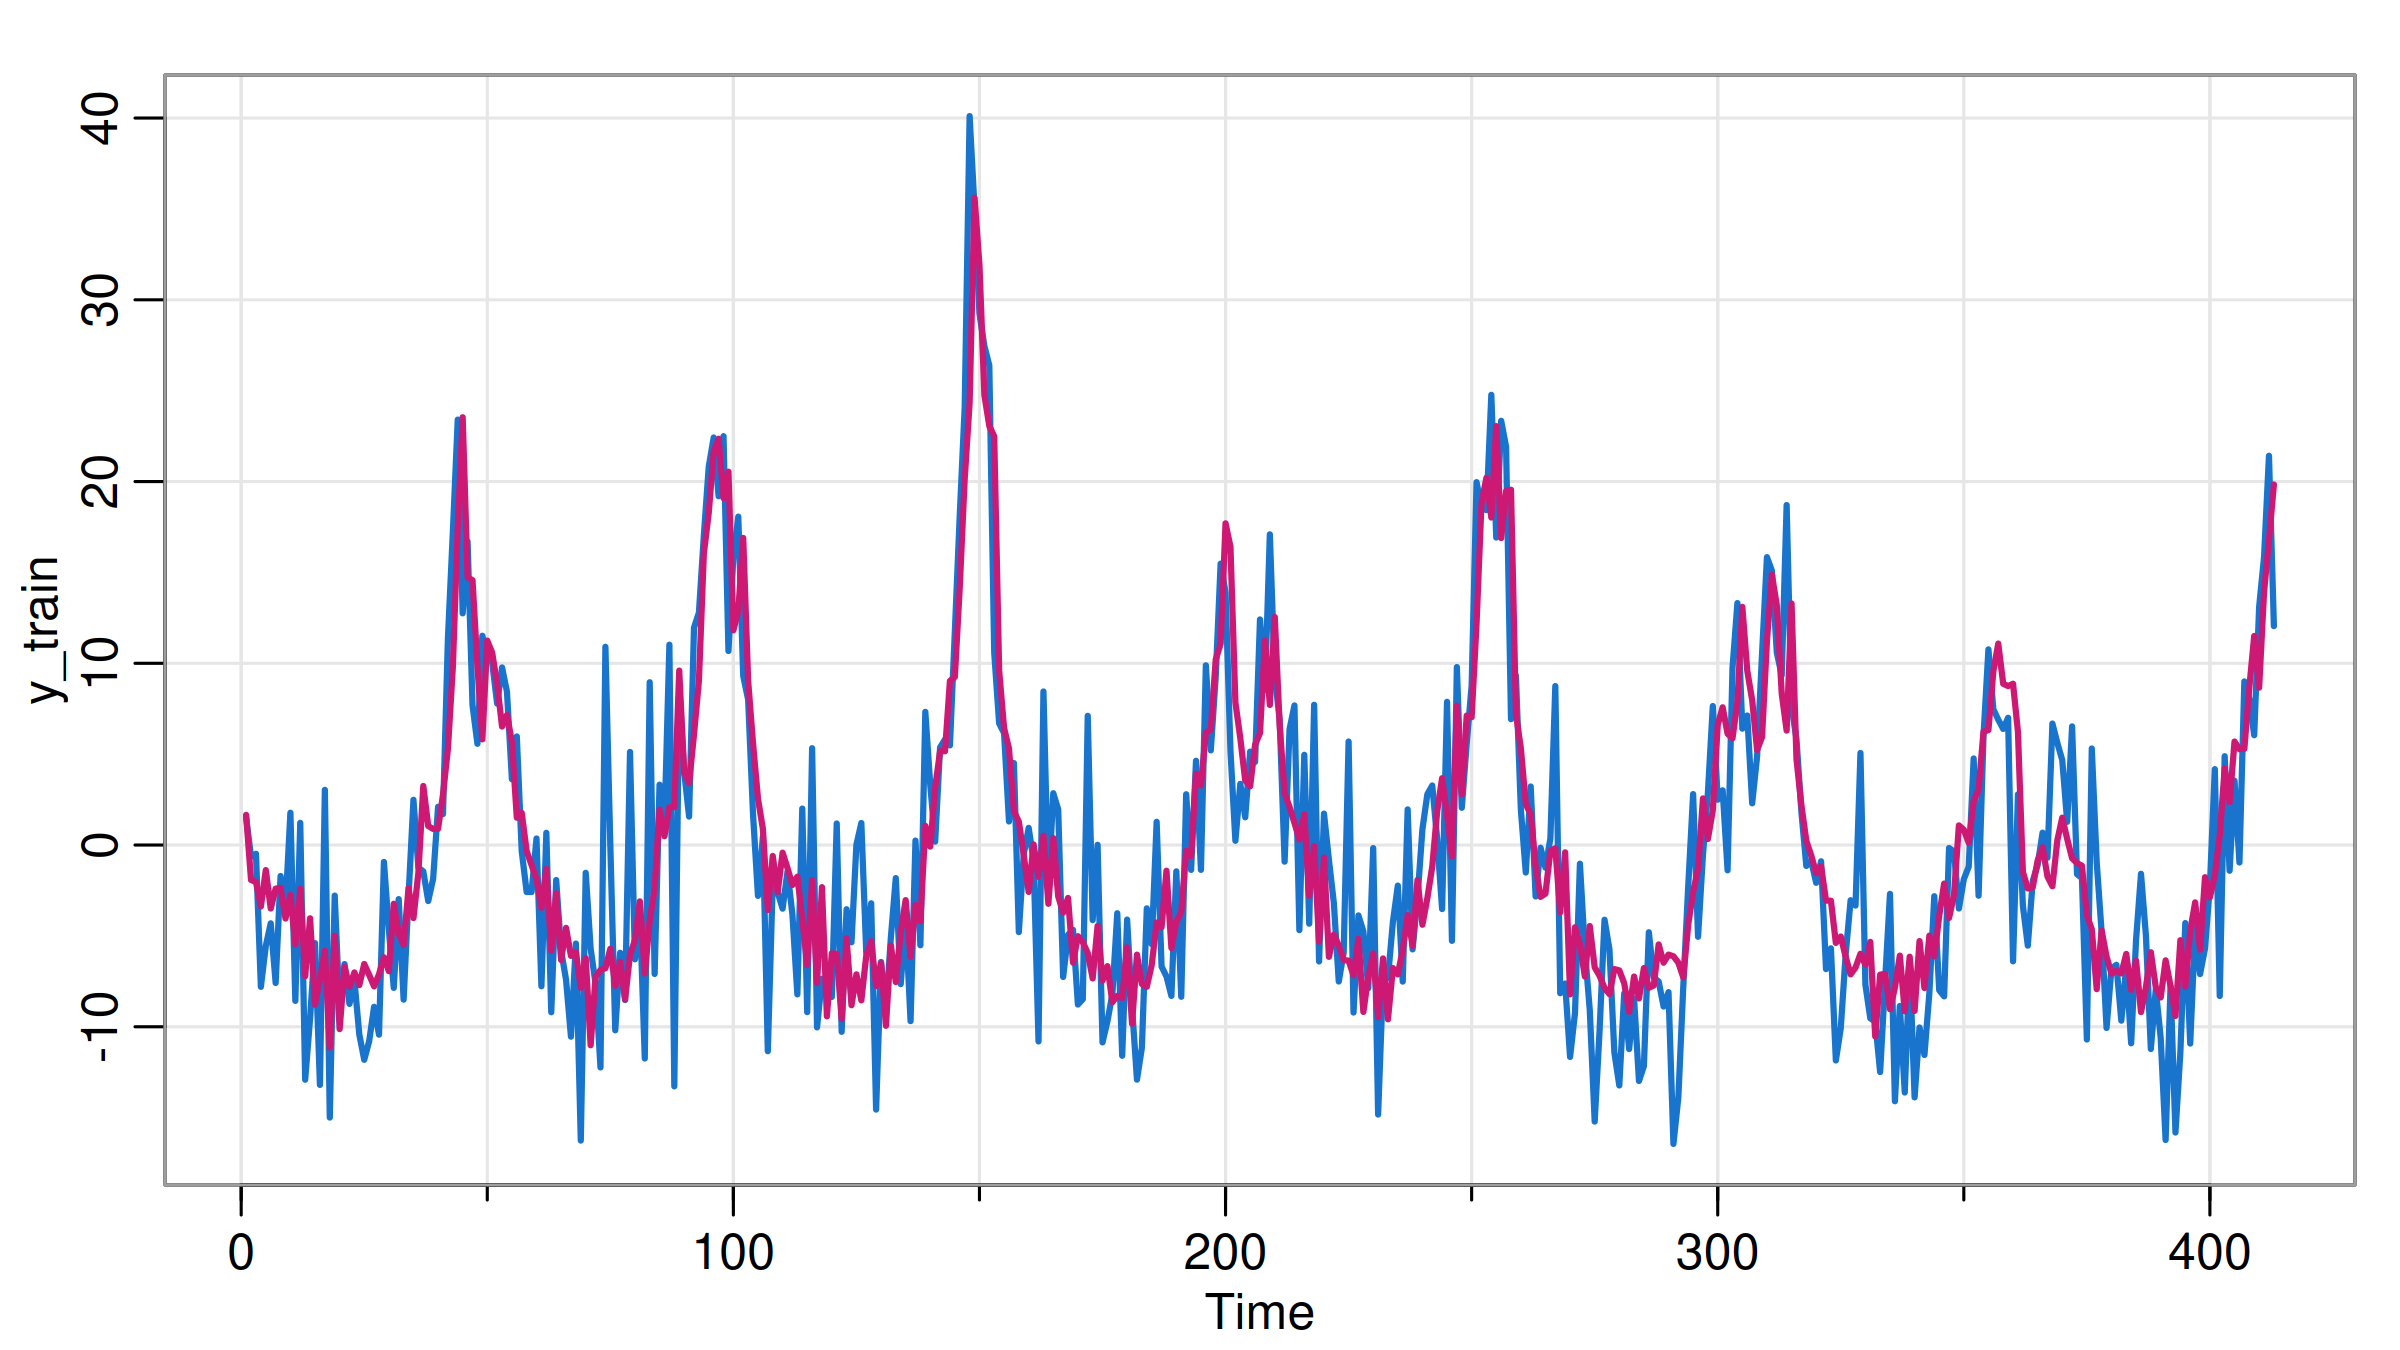

In [50]:
y5 = predict(model5,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y5, col=6, lwd=2)

## Recurrent Neural Networks

Estas redes permiten "guardar estado" y en algún sentido son la generalización no lineal del Dynamic Linear model que ya vimos. Permiten en algún sentido agregar memoria.

El proceso en una capa RNN es:

![RNN](../images/rnn.png)

## Modelo 6: Simple RNN

La red recurrente simple tiene "memoria corta" y presenta problemas de ajuste ("vanishing and exploding gradiemts") cuando uno hace el algoritmo de Backpropagation adaptado a las mismas.

In [51]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [52]:
summary(model6)

Model: "sequential_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 simple_rnn (SimpleRNN)             (None, 8)                       96          
 dense_9 (Dense)                    (None, 1)                       9           
Total params: 105
Trainable params: 105
Non-trainable params: 0
________________________________________________________________________________


In [53]:
model6 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [54]:
trained_model6 <- model6 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


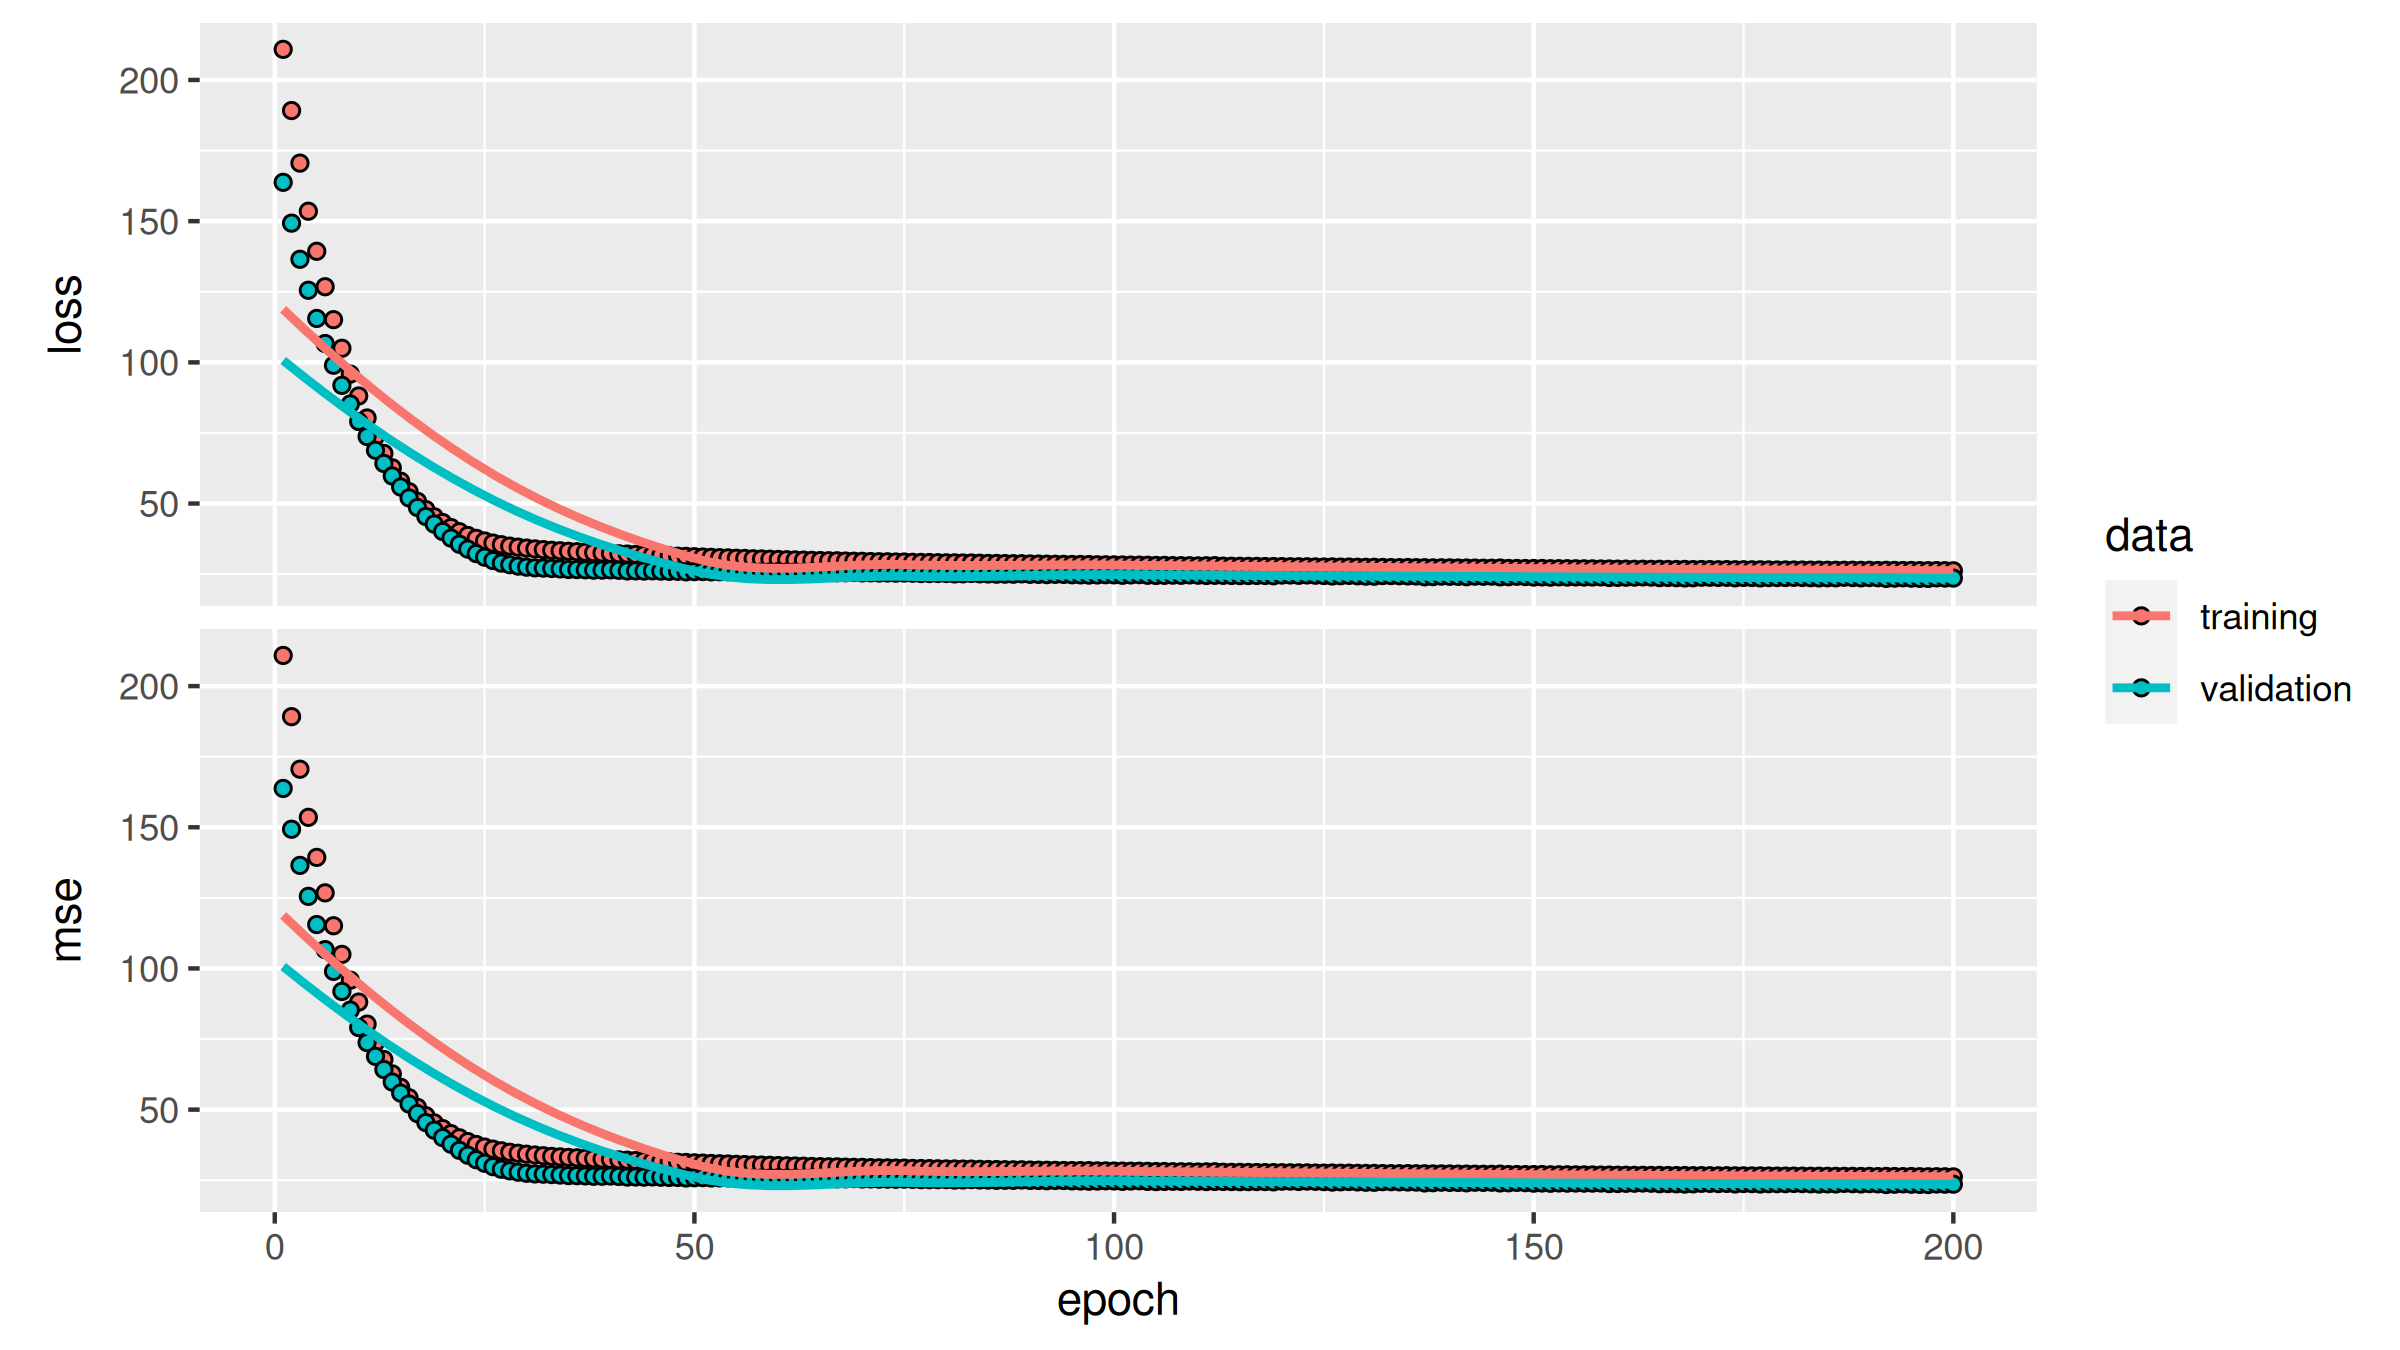

In [55]:
plot(trained_model6)

In [56]:
evaluate(model6, X_train, y_train)

loss      mse 
25.88044 25.88044

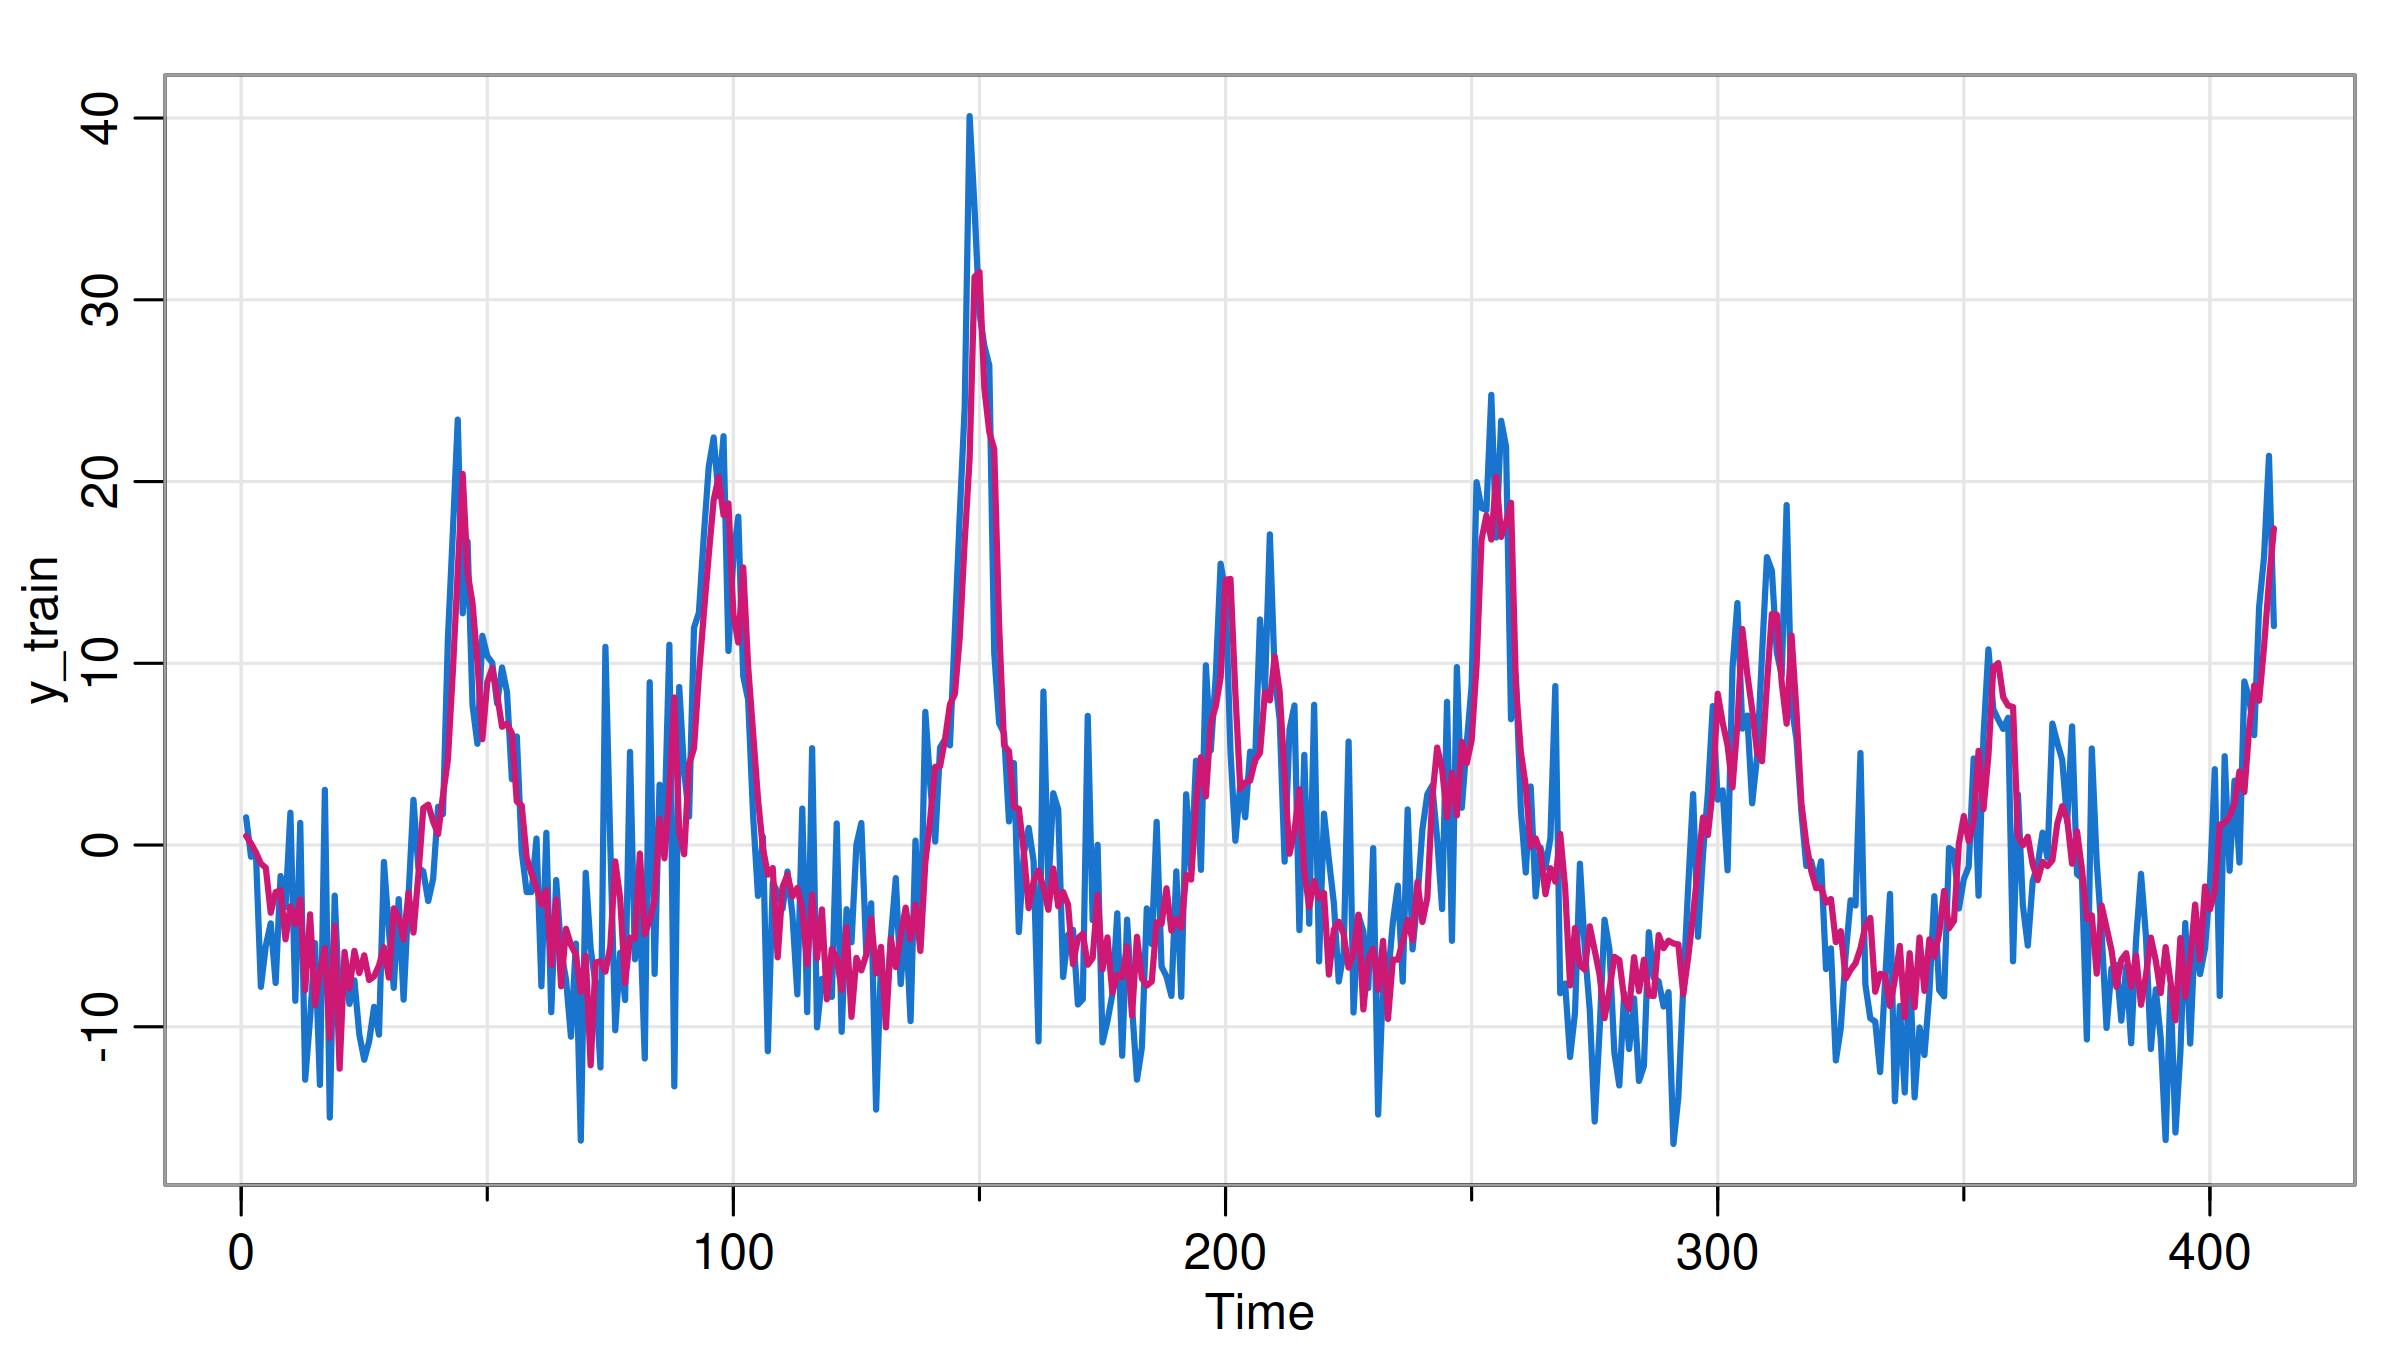

In [57]:
y6 = predict(model6,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y6, col=6, lwd=2)

## Modelo 7: LSTM

La red recurrente LSTM funciona igual que la red RNN en principio, pero tiene más "gates" y parámetros internos para permitir guardar más estado interno. Estas redes son muy usadas para series temporales.

In [58]:
# initialize our model
model7 <- keras_model_sequential()

model7 %>%
    layer_lstm(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [59]:
summary(model7)

Model: "sequential_6"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm (LSTM)                        (None, 8)                       384         
 dense_10 (Dense)                   (None, 1)                       9           
Total params: 393
Trainable params: 393
Non-trainable params: 0
________________________________________________________________________________


In [60]:
model7 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [61]:
trained_model7 <- model7 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


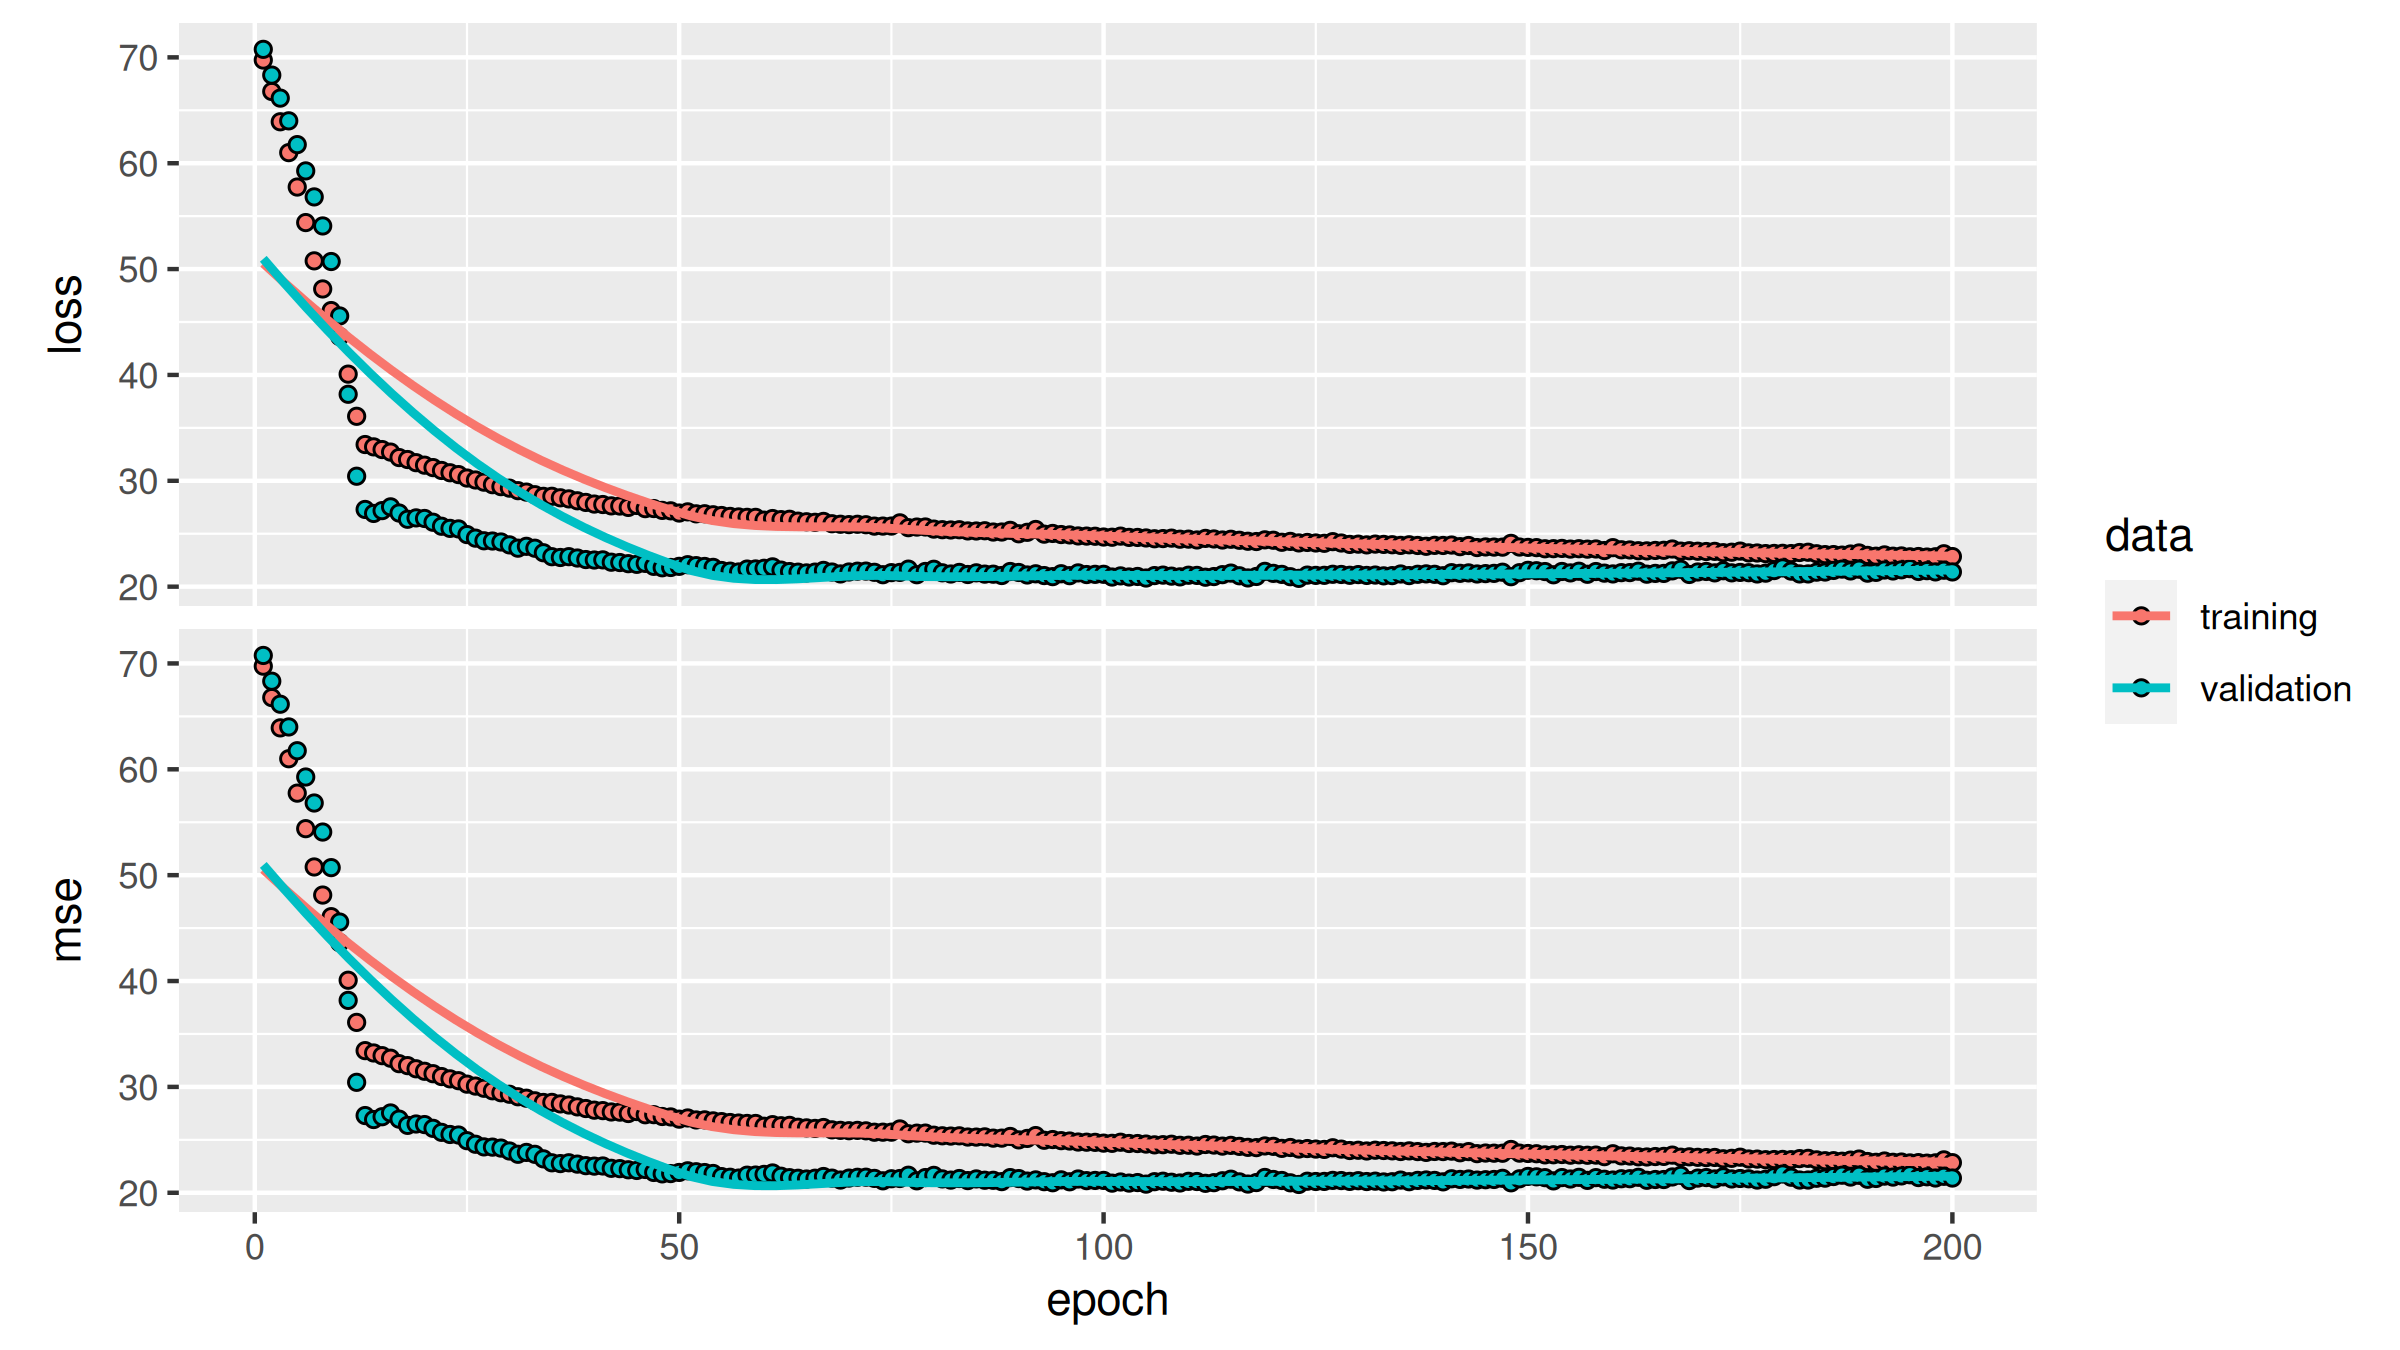

In [62]:
plot(trained_model7)

In [63]:
evaluate(model7, X_train, y_train)

loss      mse 
22.53972 22.53972

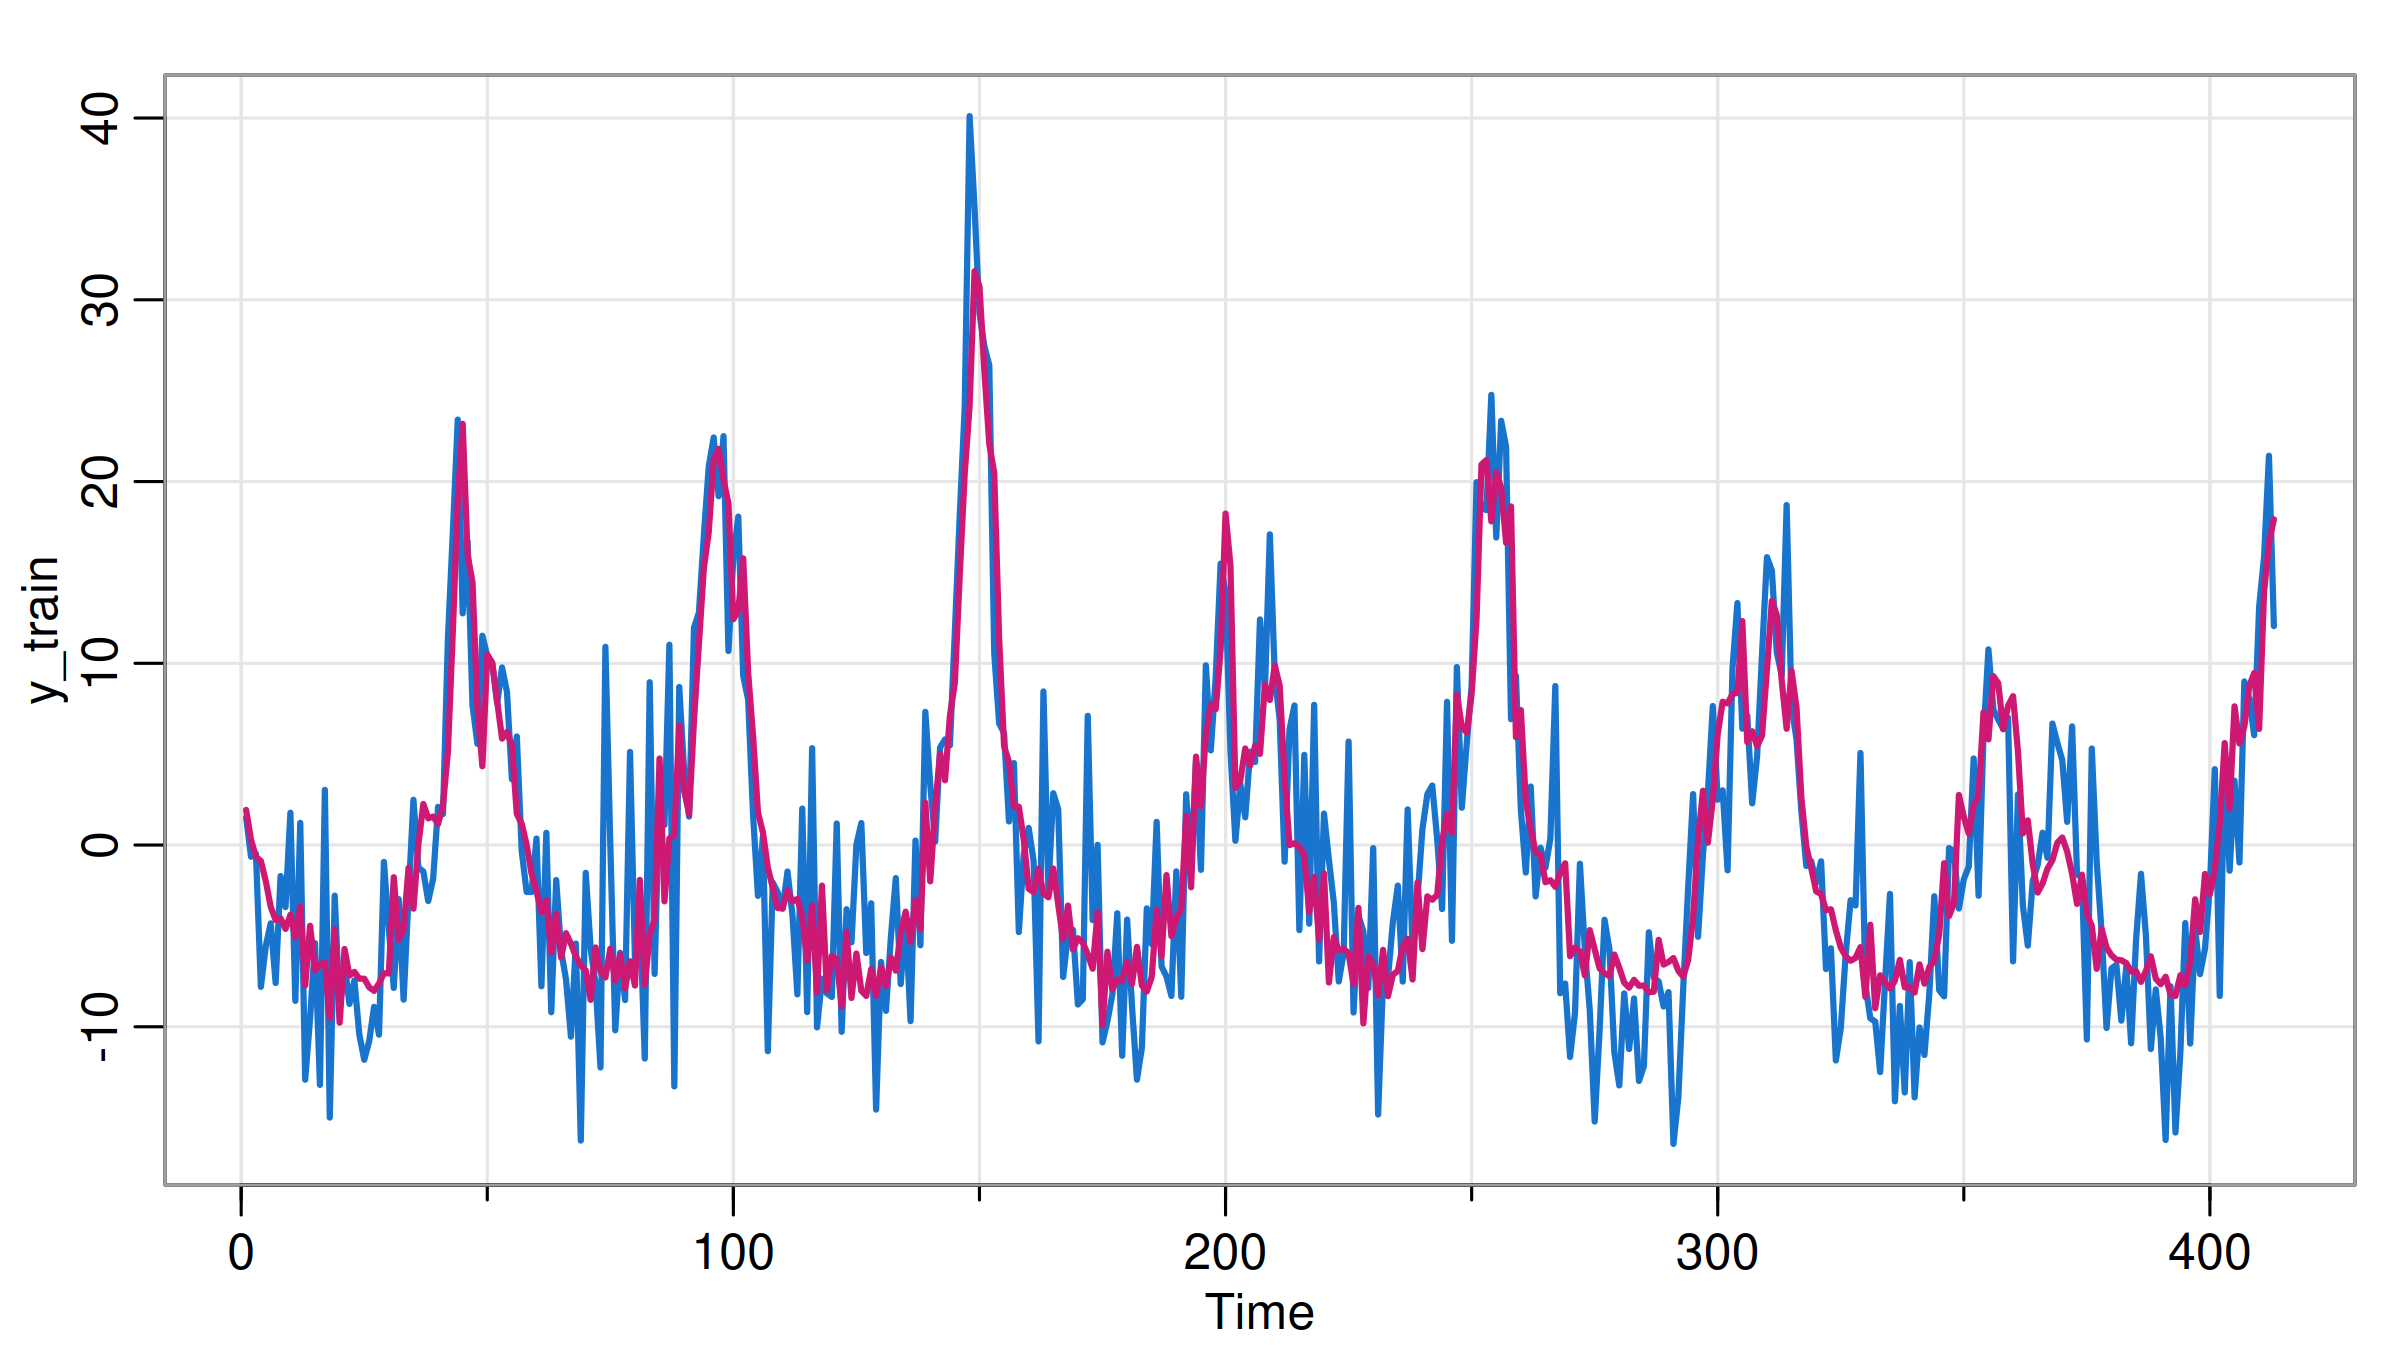

In [64]:
y7 = predict(model7,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y7, col=6, lwd=2)

## Modelo 8: LSTM +  capas

Agreguemos alguna capa densa más.

In [65]:
# initialize our model
model8 <- keras_model_sequential()

model8 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 8, activation = "relu") %>%
    layer_lstm(units = 8, activation="relu") %>%
    layer_dense(units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [66]:
summary(model8)

Model: "sequential_7"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_13 (Dense)                   (None, 3, 8)                    32          
 lstm_1 (LSTM)                      (None, 8)                       544         
 dense_12 (Dense)                   (None, 8)                       72          
 dense_11 (Dense)                   (None, 1)                       9           
Total params: 657
Trainable params: 657
Non-trainable params: 0
________________________________________________________________________________


In [67]:
model8 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [68]:
trained_model8 <- model8 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


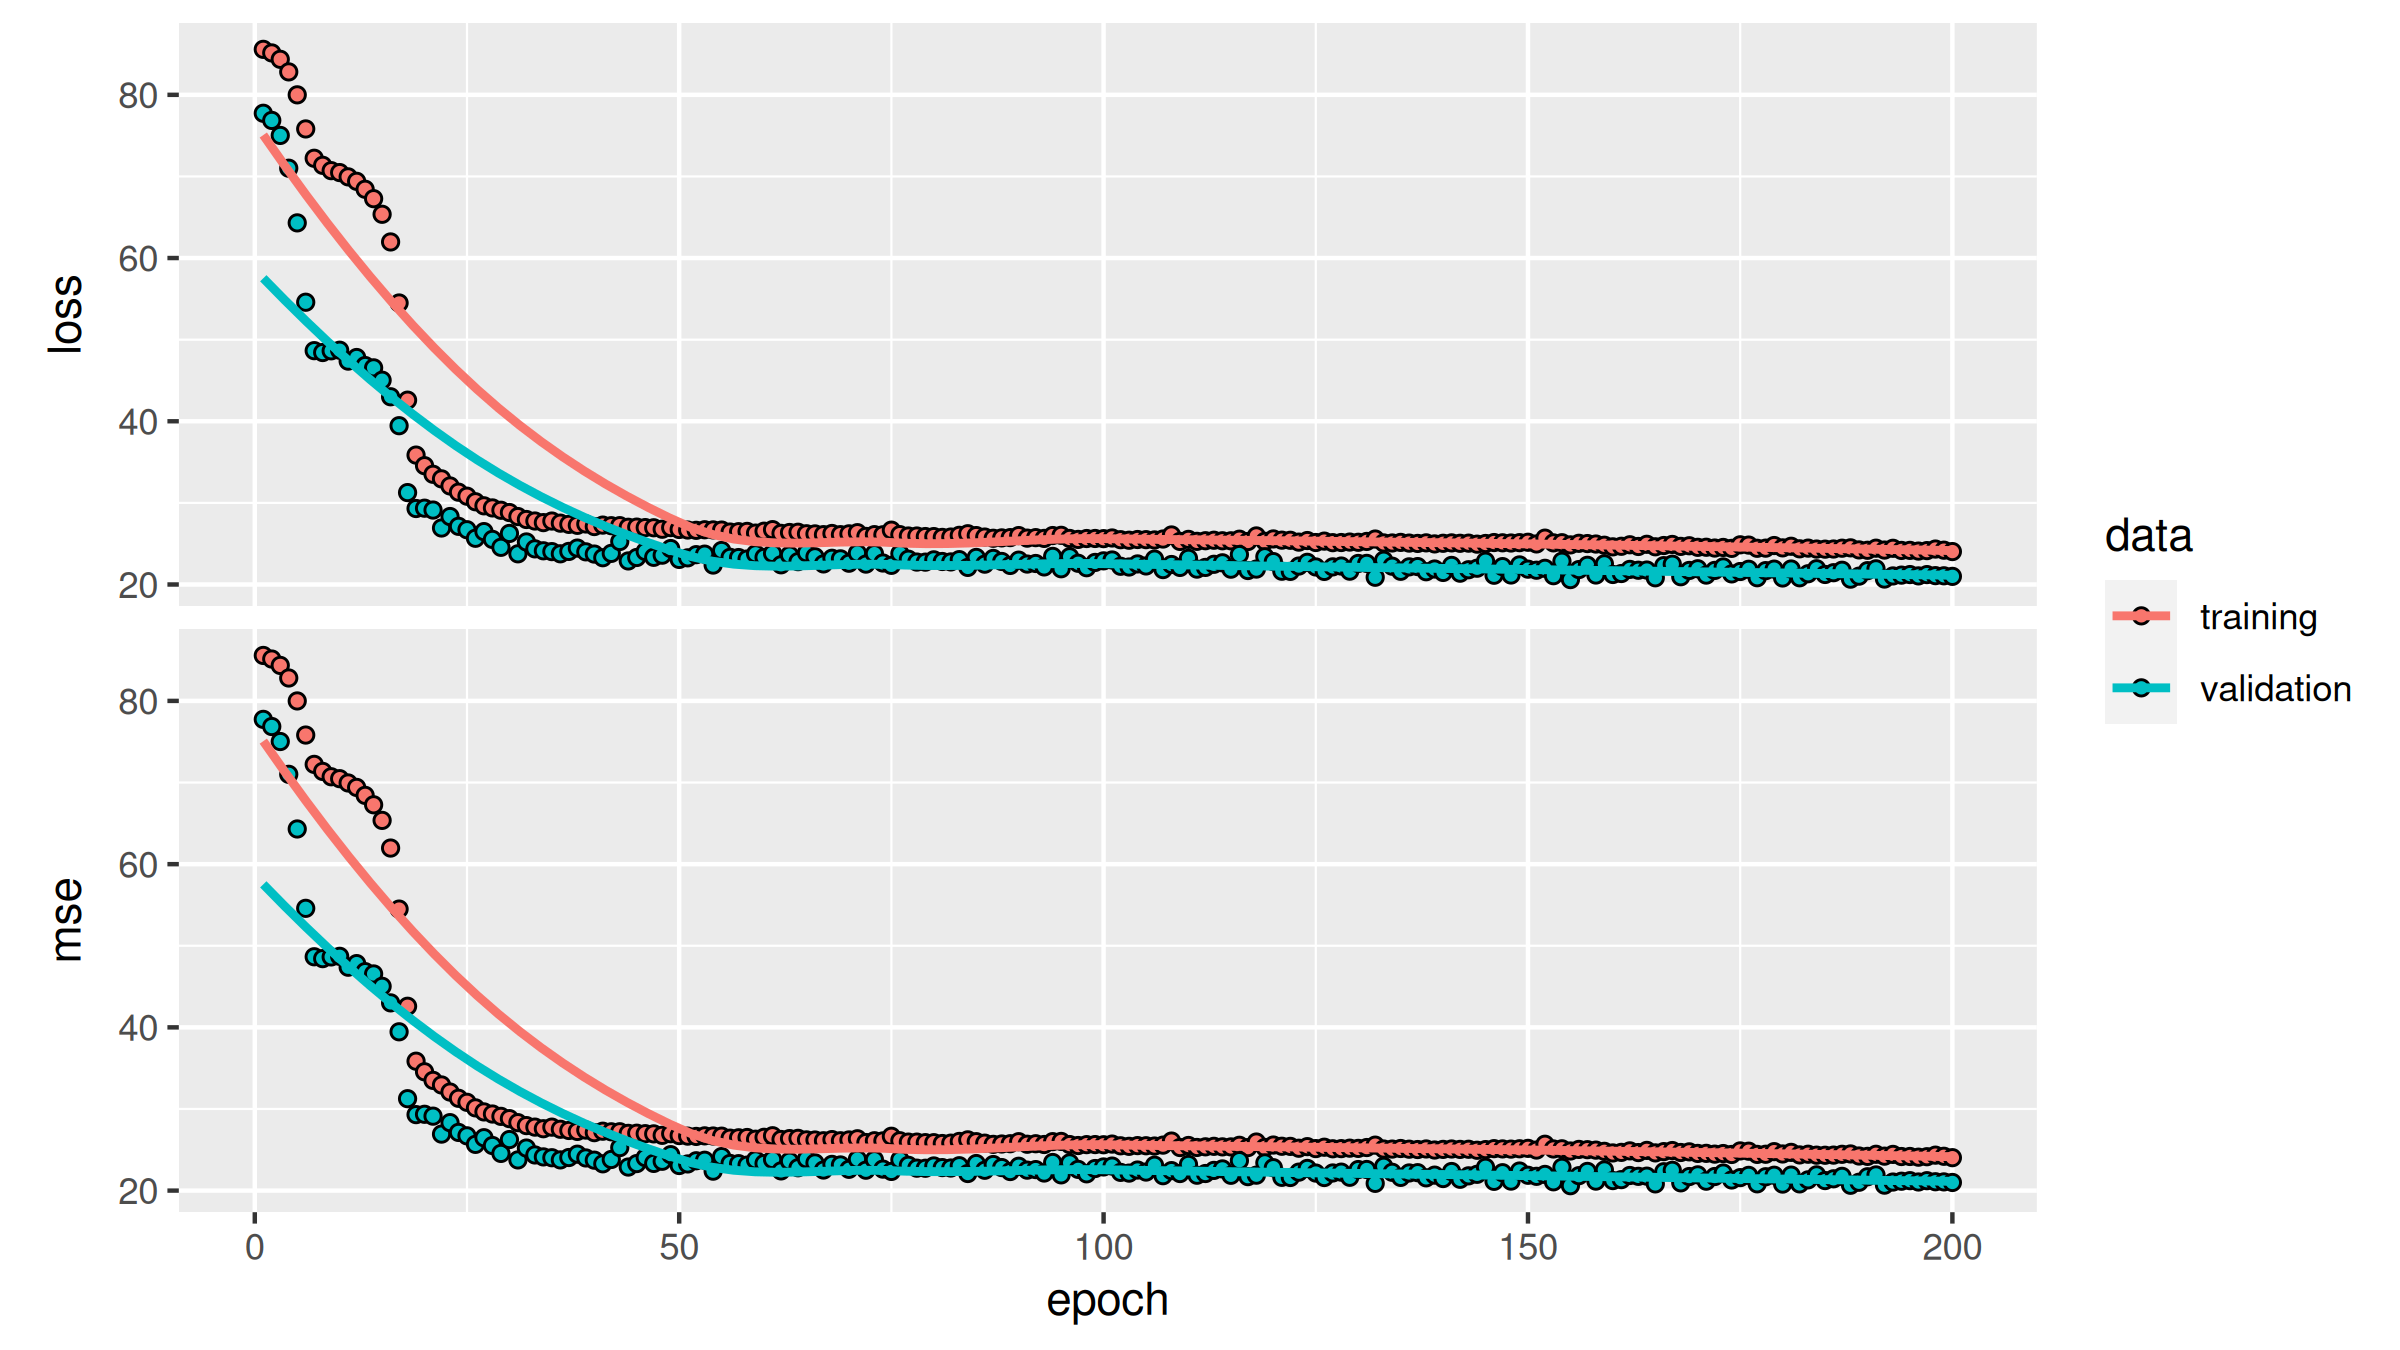

In [69]:
plot(trained_model8)

In [70]:
evaluate(model8, X_train, y_train)

loss      mse 
23.75903 23.75903

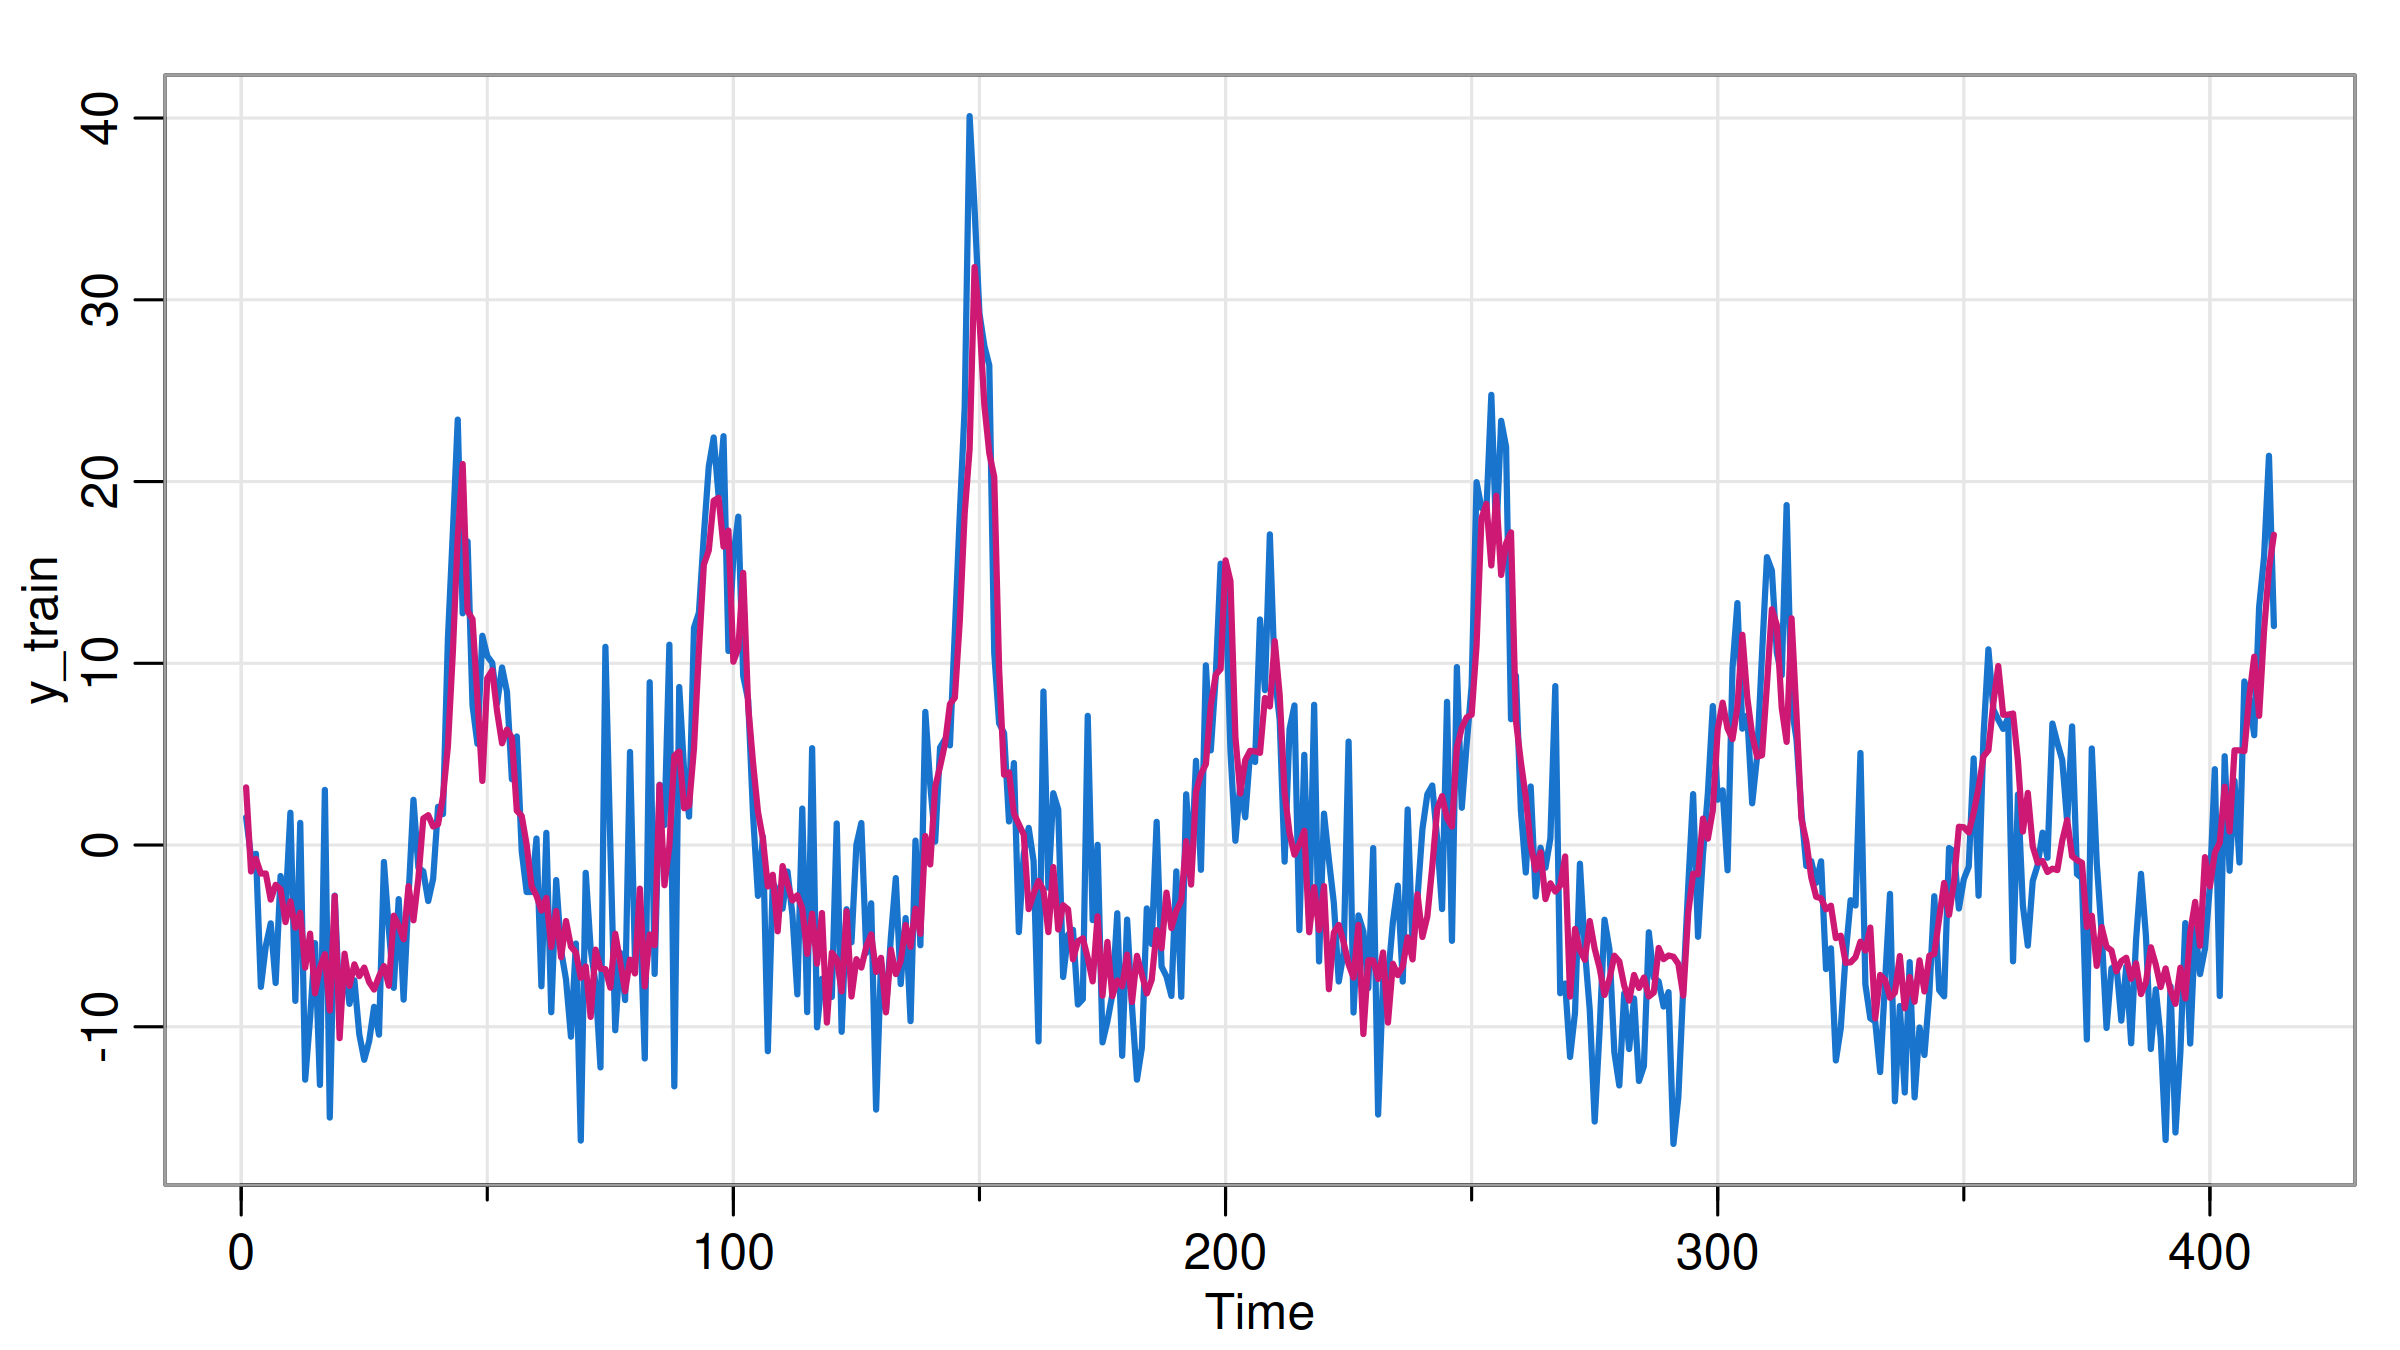

In [71]:
y8 = predict(model8,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y8, col=6, lwd=2)

## Evaluación.

Evaluemos algunos de estos modelos haciendo la predicción sobre los años que faltan.

In [72]:
x_test = x[time(x)>=1978]
x_test = ts(x_test, start=1978, freq=52)

sint = sin(2*pi*time(x_test))
cost = cos(2*pi*time(x_test))

In [73]:
n=length(x_test)

X_test = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_test = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_test[i,,1] = x[i:(i+window-1)]
    X_test[i,,2] = sint[i:(i+window-1)]
    X_test[i,,3] = cost[i:(i+window-1)]
    y_test[i,] = x[(i+window):(i+window+pred-1)]
}
dim(X_test)
dim(y_test)

[1] 89  3  3

[1] 89  1

In [74]:
evaluate(model8,X_test,y_test)

loss      mse 
27.19519 27.19519

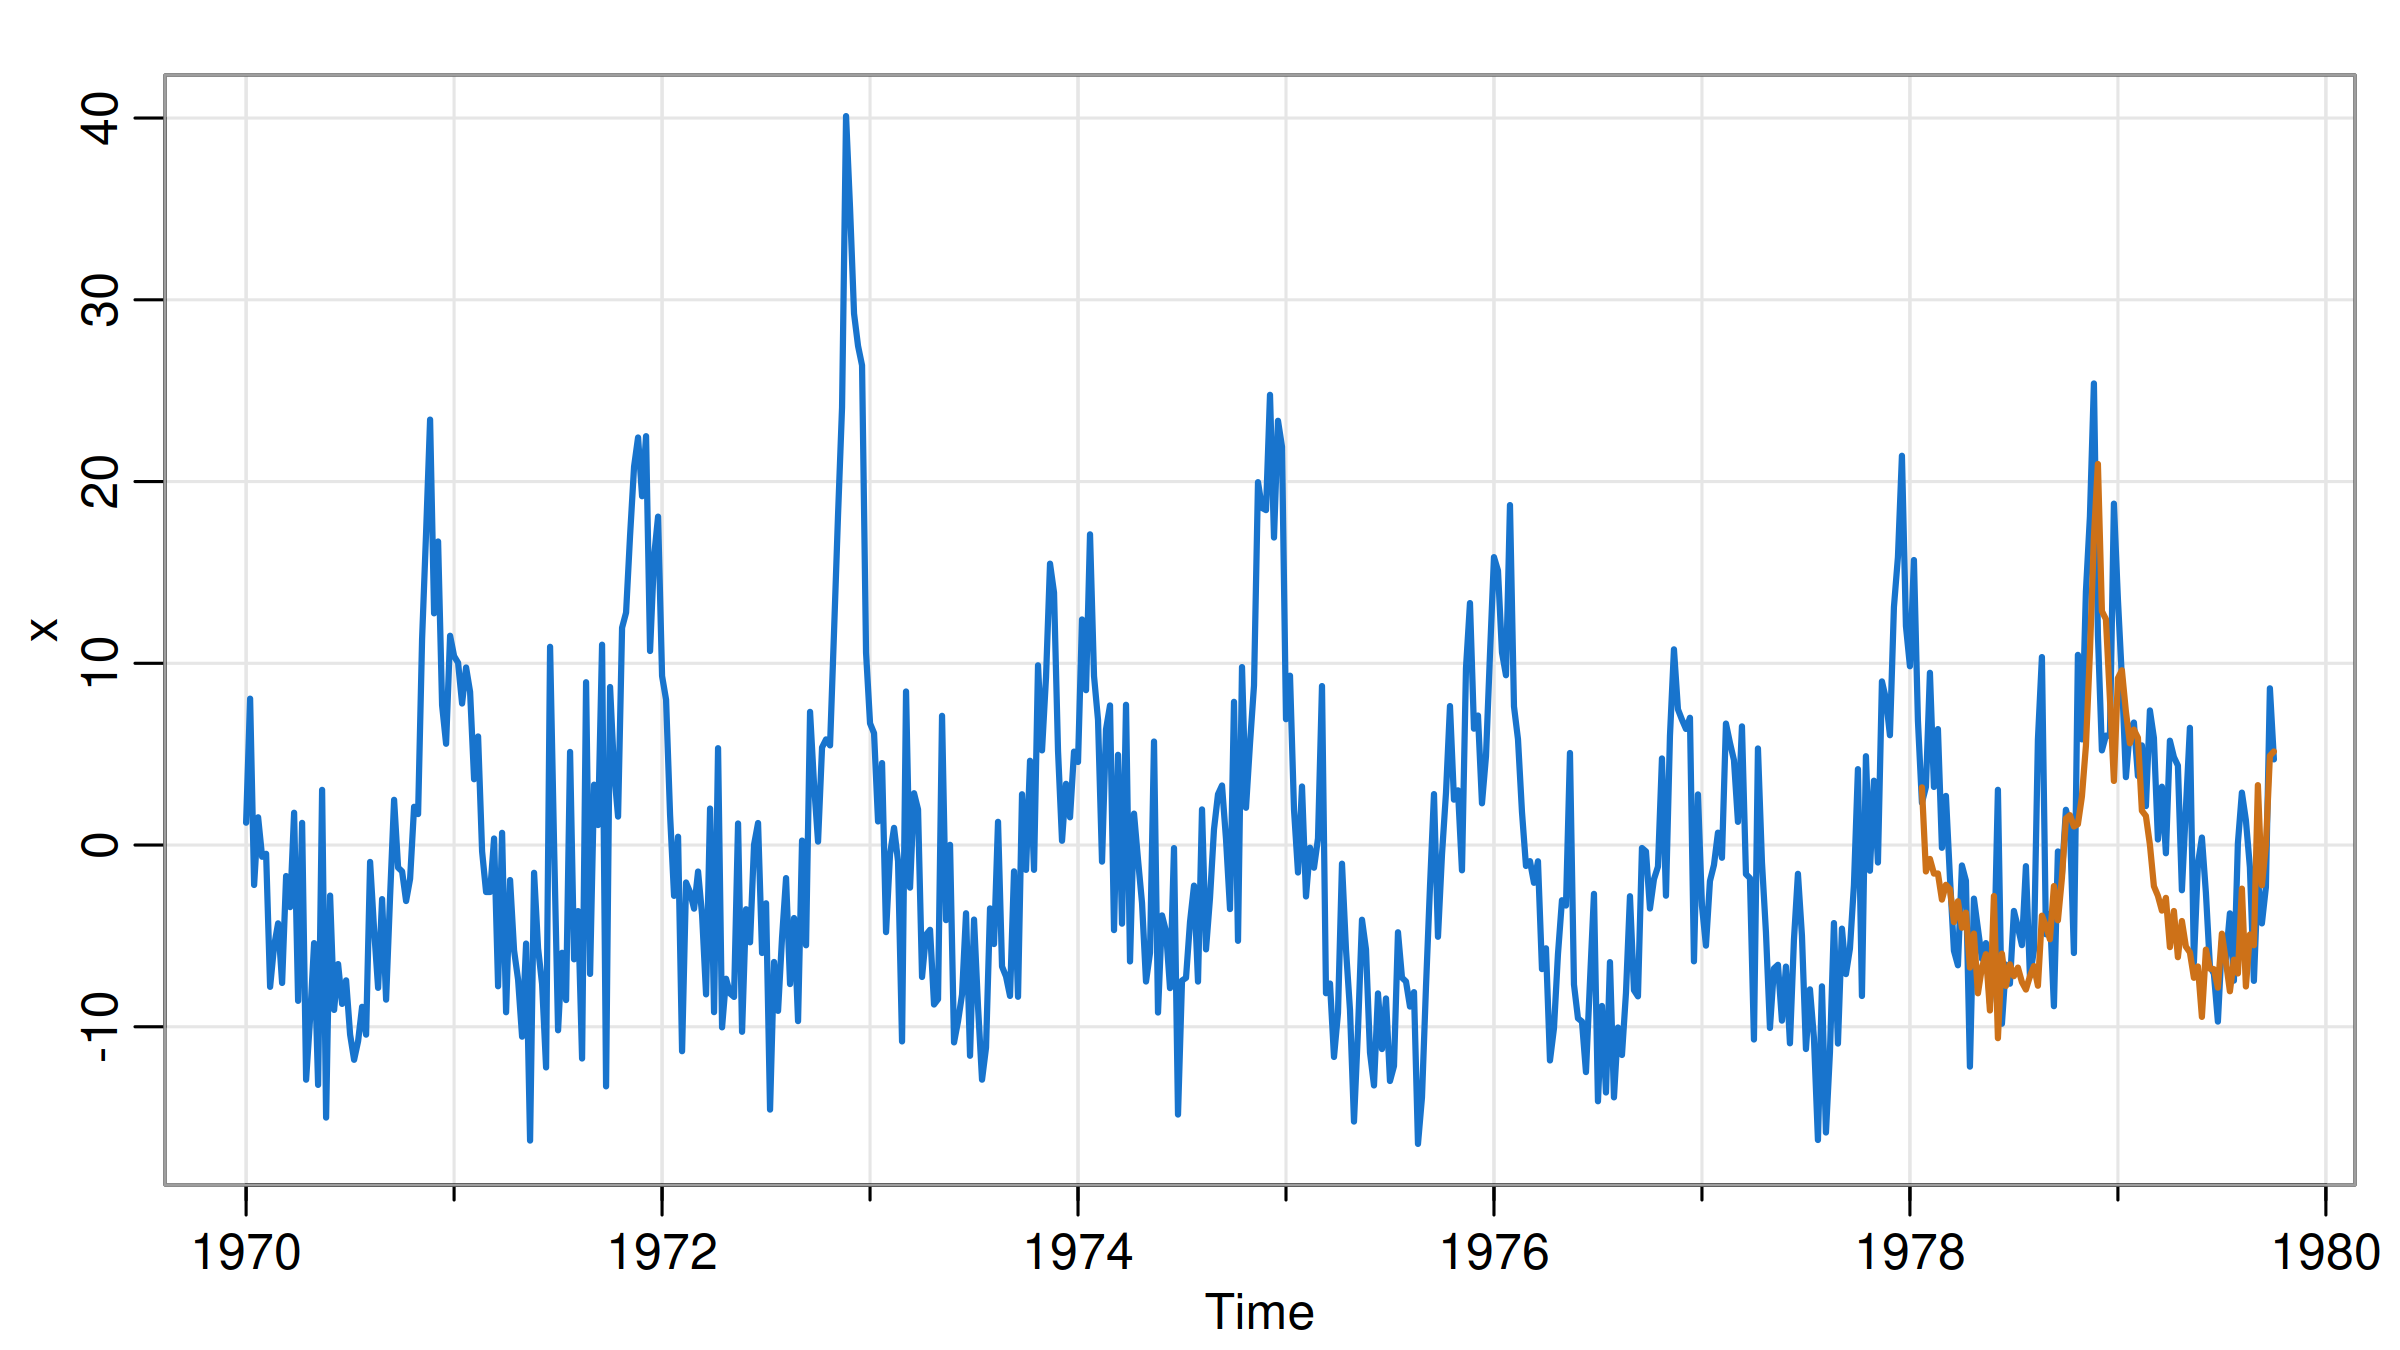

In [75]:
y8_test = predict(model8,X_test)
y8_test = ts(y8_test, start=1978+3/52, freq=52)
#y8 = ts(y8, start=1970, freq=52)

tsplot(x, col=4, lwd=2)
lines(y8, col=6, lwd=2)
lines(y8_test, col=7, lwd=2)